## LANDSLİDE MAPPİNG ON SAR DATA BY ATTENTİON U-NET, VANİLLA U-NET and ConvLSTM

# Environment & Data Access

In [ ]:
# =========================
# 1) Mount Google Drive (FINAL, clean)
# =========================
from google.colab import drive
drive.mount("/content/drive")

# # Sanity check
# !ls -la /content/drive | head
# !ls -la /content/drive/MyDrive | head


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### (Optional) Restore local dataset cache for faster I/O

⚠️ Optional.  
Only required if you have previously cached the dataset locally.  



In [ ]:
# =========================
# 2) Restore local cache (optional)
# =========================
%%bash
# (Optional) Restore local dataset cache for faster I/O
if [ -f /content/drive/MyDrive/local_sen12_cache.tar ]; then
    tar -xf /content/drive/MyDrive/local_sen12_cache.tar -C /content
    echo "✅ Local dataset cache restored"
else
    echo "ℹ️ No local cache found, using Drive dataset"
fi


✅ Local dataset cache restored


In [ ]:
# =========================
# 3) Check local cache exists
# =========================
import os

if os.path.exists("/content/local_sen12"):
    DATA_ROOT = "/content/local_sen12"
else:
    DATA_ROOT = "/content/drive/MyDrive/sen12"

print("📂 Using dataset root:", DATA_ROOT)


📂 Using dataset root: /content/local_sen12


In [ ]:
# =========================
# 4) Quick dataset check (optional)(sanity check)
# =========================

%%bash
# (Optional) Verify dataset folder exists and list a few files

if [ -d /content/local_sen12 ]; then
    echo "📂 Found local cache: /content/local_sen12"
    ls /content/local_sen12 | head -n 5
else
    echo "📂 Using Drive dataset (local cache not present)"
    ls /content/drive/MyDrive/sen12 | head -n 5
fi


📂 Found local cache: /content/local_sen12
dataset_split_seed42.txt
s1asc
s1dsc
s2


In [ ]:
# =========================
# 5) FAST_MODE + robust Drive → local sync
# make the notebook more stable + faster by using local disk when possible.
# =========================

from pathlib import Path
import os, shutil, glob, time, errno
from google.colab import drive as _colab_drive

FAST_MODE = True
REGION_FILTER = "hokkaido"

DRIVE_BASE = Path("/content/drive/MyDrive/attention_unet/sen12landslidedata")
LOCAL_BASE = Path("/content/local_sen12")

# ✅ if there is local content do not touch drive
if (LOCAL_BASE / "s1asc").exists() and (LOCAL_BASE / "s1dsc").exists() and (LOCAL_BASE / "s2").exists():
    print("✅ Local cache already present. Skipping Drive sync.")
    DATA_BASE = LOCAL_BASE

else:
    # --- DRIVE CONNECTION GUARD ---
    def ensure_drive_mounted():
        try:
            if (not os.path.ismount("/content/drive")) or (not os.path.exists("/content/drive/MyDrive")):
                print("🔄 Google Drive not mounted; mounting now ...")
                _colab_drive.mount("/content/drive", force_remount=True)
            os.listdir("/content/drive/MyDrive")
        except OSError as e:
            if getattr(e, "errno", None) == 107:
                print("🔄 Drive connection dropped (Errno 107). Re-mounting ...")
                _colab_drive.mount("/content/drive", force_remount=True)
                time.sleep(1)
                os.listdir("/content/drive/MyDrive")
            else:
                raise

    # auto-detect
    if not DRIVE_BASE.exists():
        print("⚠️ DRIVE_BASE not found:", DRIVE_BASE)
        candidates = glob.glob("/content/drive/MyDrive/**/sen12landslidedata", recursive=True)
        if candidates:
            DRIVE_BASE = Path(candidates[0])
            print("✅ Auto-detected DRIVE_BASE:", DRIVE_BASE)
        else:
            raise FileNotFoundError("❌ Could not auto-detect sen12landslidedata under MyDrive.")

    def _sync_to_local(src_dir: Path, dst_dir: Path, pattern: str, max_retries: int = 3):
        dst_dir.mkdir(parents=True, exist_ok=True)
        ensure_drive_mounted()
        files = sorted(src_dir.glob(pattern))
        for f in files:
            dst = dst_dir / f.name
            if dst.exists() and dst.stat().st_size == f.stat().st_size:
                continue
            for attempt in range(1, max_retries + 1):
                try:
                    shutil.copy2(f, dst)
                    break
                except OSError as e:
                    if getattr(e, "errno", None) == 107 and attempt < max_retries:
                        print(f"🔄 Drive disconnected while copying {f.name}; remounting ...")
                        ensure_drive_mounted()
                        time.sleep(1)
                        continue
                    raise
        return len(files)

    if FAST_MODE:
        print("FAST_MODE enabled ✅")
        subfolders = ["s1asc", "s1dsc", "s2"]
        for sf in subfolders:
            (LOCAL_BASE / sf).mkdir(parents=True, exist_ok=True)

        patt = f"*{REGION_FILTER}*.nc"
        n_a = _sync_to_local(DRIVE_BASE / "s1asc", LOCAL_BASE / "s1asc", patt)
        n_d = _sync_to_local(DRIVE_BASE / "s1dsc", LOCAL_BASE / "s1dsc", patt)
        n_2 = _sync_to_local(DRIVE_BASE / "s2",    LOCAL_BASE / "s2",    patt)

        print(f"Copied to local: s1asc={n_a}, s1dsc={n_d}, s2={n_2}")
        DATA_BASE = LOCAL_BASE
    else:
        print("FINAL_MODE enabled ✅ (using Drive paths)")
        DATA_BASE = DRIVE_BASE

print("DATA_BASE:", DATA_BASE)

# time/training settings (aynı kalsın)
TIME_STEPS = 4
TIME_SAMPLING = "even"
MASK_TIME = "last"

EPOCHS_FAST  = 20
EPOCHS_FINAL = 80
PATIENCE     = 4
EPOCHS = EPOCHS_FAST if FAST_MODE else EPOCHS_FINAL

print("TIME_STEPS:", TIME_STEPS, "| TIME_SAMPLING:", TIME_SAMPLING, "| MASK_TIME:", MASK_TIME)
print("EPOCHS:", EPOCHS, "| PATIENCE:", PATIENCE)


✅ Local cache already present. Skipping Drive sync.
DATA_BASE: /content/local_sen12
TIME_STEPS: 4 | TIME_SAMPLING: even | MASK_TIME: last
EPOCHS: 20 | PATIENCE: 4


In [ ]:
# =========================
# 6) Sets VERBOSE_FILES for printing filenames (debug convenience)
# =========================

VERBOSE_FILES = False  # set True to print example filenames

from pathlib import Path

# DATA_BASE is set in Cell 1b (FAST_MODE uses local cache; FINAL_MODE uses Drive)
BASE = DATA_BASE

for folder in ["s1asc", "s1dsc", "s2"]:
    path = BASE / folder
    nc_files = sorted(path.glob("*.nc"))

    print(f"\n📁 {folder}")
    print(f"Total .nc files: {len(nc_files)}")

    if VERBOSE_FILES:
        for f in nc_files[:22]:
            print("  ", f.name)



📁 s1asc
Total .nc files: 300

📁 s1dsc
Total .nc files: 300

📁 s2
Total .nc files: 290


In [ ]:
# =========================
# 7) general imports
# Imports standard libraries used later.
# =========================

import os, sys, random, math
from pathlib import Path

import numpy as np
import xarray as xr
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import (
    Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate,
    Conv2DTranspose, BatchNormalization, Dropout, Lambda
)
from tensorflow.keras.optimizers import Adam

print("TensorFlow:", tf.__version__)
print("GPU devices:", tf.config.list_physical_devices("GPU"))

# 4) (Optional) Speed / stability settings
tf.keras.backend.clear_session()
AUTOTUNE = tf.data.AUTOTUNE


TensorFlow: 2.19.0
GPU devices: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [ ]:
# =========================
# 8) Set dataset directories
# =========================
from pathlib import Path

# DATA_BASE comes from Cell 1b
BASE = Path(str(DATA_BASE))

S1ASC_DIR = BASE / "s1asc"
S1DSC_DIR = BASE / "s1dsc"
S2_DIR    = BASE / "s2"

assert S1ASC_DIR.exists(), f"Missing: {S1ASC_DIR}"
assert S1DSC_DIR.exists(), f"Missing: {S1DSC_DIR}"
assert S2_DIR.exists(),    f"Missing: {S2_DIR}"

print("Using dataset at:", BASE)


Using dataset at: /content/local_sen12


In [ ]:
# =========================
# 9) Index & match files across modalities (s1asc/s1dsc/s2)
# =========================

def key_from_filename(name: str) -> str:
    """
    Example names:
      chimanimani_s1asc_1000.nc
      chimanimani_s1dsc_1000.nc
      chimanimani_s2_1000.nc
    Key should match across modalities.
    """
    name = name.replace(".nc", "")
    # remove modality token
    name = name.replace("_s1asc_", "_")
    name = name.replace("_s1dsc_", "_")
    name = name.replace("_s2_", "_")
    return name  # e.g., hokkaido_s1_1000

def build_index(folder: Path):
    idx = {}
    for p in folder.glob("*.nc"):
        idx[key_from_filename(p.name)] = p
    return idx

idx_a = build_index(S1ASC_DIR)
idx_d = build_index(S1DSC_DIR)
idx_2 = build_index(S2_DIR)

keys = sorted(set(idx_a) & set(idx_d) & set(idx_2))

# Optional: filter by region substring in FAST_MODE
if FAST_MODE and REGION_FILTER:
    keys_before = len(keys)
    keys = [k for k in keys if REGION_FILTER.lower() in idx_2[k].name.lower()]
    print(f"FAST_MODE filter '{REGION_FILTER}': {keys_before} -> {len(keys)} matched triplets")

print("Matched tiles:", len(keys))

# Show a few examples
for k in keys[:5]:
    print(" ", k, "->", idx_a[k].name, idx_d[k].name, idx_2[k].name)

assert len(keys) > 0, "No matching keys found. Check filename patterns."

print("S1ASC only:", len(set(idx_a) - set(idx_d) - set(idx_2)))
print("S1DSC only:", len(set(idx_d) - set(idx_a) - set(idx_2)))
print("S2 only:",    len(set(idx_2) - set(idx_a) - set(idx_d)))



FAST_MODE filter 'hokkaido': 290 -> 290 matched triplets
Matched tiles: 290
  hokkaido_1006 -> hokkaido_s1asc_1006.nc hokkaido_s1dsc_1006.nc hokkaido_s2_1006.nc
  hokkaido_1017 -> hokkaido_s1asc_1017.nc hokkaido_s1dsc_1017.nc hokkaido_s2_1017.nc
  hokkaido_1020 -> hokkaido_s1asc_1020.nc hokkaido_s1dsc_1020.nc hokkaido_s2_1020.nc
  hokkaido_1026 -> hokkaido_s1asc_1026.nc hokkaido_s1dsc_1026.nc hokkaido_s2_1026.nc
  hokkaido_1033 -> hokkaido_s1asc_1033.nc hokkaido_s1dsc_1033.nc hokkaido_s2_1033.nc
S1ASC only: 0
S1DSC only: 0
S2 only: 0


In [ ]:
# =========================
# 10) Inspect ONE NetCDF (SEN12-aware)
# =========================

def open_nc(path):
    # Always use this for SEN12 files
    return xr.open_dataset(path, engine="h5netcdf", cache=False)

# Pick one matched tile (S2 first)
sample_key  = keys[0]
sample_path = idx_2[sample_key]

ds = open_nc(sample_path)

print("=== DATASET SUMMARY ===")
print(ds)

print("\n=== VARIABLES ===")
for v in ds.data_vars:
    a = ds[v]
    shp = tuple(a.shape)
    dtype = a.dtype

    # Simple semantic hints
    hint = ""
    if v.upper() == "MASK":
        hint = "<-- LABEL (landslide mask)"
    elif v.startswith("B"):
        hint = "<-- S2 spectral band"
    elif v in ["DEM", "SCL"]:
        hint = "<-- auxiliary (optional)"

    print(f"- {v:12s} shape={shp} dtype={dtype} {hint}")

print("\n=== DIMENSIONS ===")
for k, v in ds.dims.items():
    print(f"{k}: {v}")

print("\n=== COORDINATES ===")
for c in ds.coords:
    print(c)

# Explicit conclusions for SEN12
print("\n=== INTERPRETATION (IMPORTANT) ===")
print("""
• All image bands and MASK are 3D: (time, x, y)
• This is a TIME-SERIES dataset, not single images
• MASK is NOT 2D here — you must select a time index
• Typical training choice:
    - image  = bands at time t (e.g. t = -1)
    - label  = MASK at same time t
""")


=== DATASET SUMMARY ===
<xarray.Dataset> Size: 6MB
Dimensions:      (time: 15, x: 128, y: 128)
Coordinates:
  * time         (time) datetime64[ns] 120B 2018-02-22 2018-03-29 ... 2019-03-04
  * x            (x) float64 1kB 5.901e+05 5.901e+05 ... 5.913e+05 5.914e+05
  * y            (y) float64 1kB 4.716e+06 4.716e+06 ... 4.714e+06 4.714e+06
Data variables: (12/14)
    B02          (time, x, y) int16 492kB ...
    B03          (time, x, y) int16 492kB ...
    B04          (time, x, y) int16 492kB ...
    B05          (time, x, y) int16 492kB ...
    B06          (time, x, y) int16 492kB ...
    B07          (time, x, y) int16 492kB ...
    ...           ...
    B11          (time, x, y) int16 492kB ...
    B12          (time, x, y) int16 492kB ...
    SCL          (time, x, y) int16 492kB ...
    MASK         (time, x, y) uint8 246kB ...
    DEM          (time, x, y) int16 492kB ...
    spatial_ref  int64 8B ...
Attributes:
    ann_id:           
    ann_bbox:         
    event_date:  

/tmp/ipython-input-3352225068.py:34: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  for k, v in ds.dims.items():
<frozen _collections_abc>:894: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


In [ ]:
# =========================
# 11) Deterministic train/val/test split (seeded)
# =========================
import random, os

SPLIT_SEED = 42
random.Random(SPLIT_SEED).shuffle(keys)

n = len(keys)
n_train = int(0.8 * n)
n_val   = int(0.1 * n)

train_keys = keys[:n_train]
val_keys   = keys[n_train:n_train + n_val]
test_keys  = keys[n_train + n_val:]

print("Total:", n, "| Train:", len(train_keys), "| Val:", len(val_keys), "| Test:", len(test_keys))
print("First train/val/test keys:", train_keys[0], val_keys[0], test_keys[0])

# Save split for reproducibility (per model OUT_DIR)
split_path = os.path.join(OUT_DIR, "dataset_split.txt") if "OUT_DIR" in globals() else "/content/dataset_split.txt"
with open(split_path, "w") as f:
    f.write(f"seed={SPLIT_SEED}\n")
    f.write("TRAIN\n" + "\n".join(train_keys) + "\n")
    f.write("VAL\n"   + "\n".join(val_keys)   + "\n")
    f.write("TEST\n"  + "\n".join(test_keys)  + "\n")

print("✅ Saved split:", split_path)

# Save split to a persistent place (recommended)
persistent_split = os.path.join(str(DATA_BASE), "dataset_split_seed42.txt")
with open(persistent_split, "w") as f:
    f.write(f"seed={SPLIT_SEED}\n")
    f.write("TRAIN\n" + "\n".join(train_keys) + "\n")
    f.write("VAL\n"   + "\n".join(val_keys)   + "\n")
    f.write("TEST\n"  + "\n".join(test_keys)  + "\n")
print("✅ Saved persistent split:", persistent_split)


Total: 290 | Train: 232 | Val: 29 | Test: 29
First train/val/test keys: hokkaido_962 hokkaido_903 hokkaido_538
✅ Saved split: /content/dataset_split.txt
✅ Saved persistent split: /content/local_sen12/dataset_split_seed42.txt


In [ ]:
# =========================
# 12) Load the saved split file
# =========================
import os

split_file = os.path.join(str(DATA_BASE), "dataset_split_seed42.txt")
assert os.path.exists(split_file), f"Missing split file: {split_file}"

with open(split_file, "r") as f:
    lines = [ln.strip() for ln in f if ln.strip()]

assert lines[0].startswith("seed=")

def _read_block(tag):
    i = lines.index(tag) + 1
    out = []
    while i < len(lines) and lines[i] not in ("TRAIN","VAL","TEST"):
        out.append(lines[i])
        i += 1
    return out

train_keys = _read_block("TRAIN")
val_keys   = _read_block("VAL")
test_keys  = _read_block("TEST")

print("✅ Loaded split:", split_file)
print("Train/Val/Test:", len(train_keys), len(val_keys), len(test_keys))
print("Example:", train_keys[0], val_keys[0], test_keys[0])


✅ Loaded split: /content/local_sen12/dataset_split_seed42.txt
Train/Val/Test: 232 29 29
Example: hokkaido_962 hokkaido_903 hokkaido_538


# Data Loading & Preprocessing Pipeline

In [ ]:
# =========================
# 13) Define preprocessing options + compute input channels
# =========================

# =========================
# 13-A) TIME HANDLING
# =========================
# TIME_STEPS / TIME_SAMPLING are defined in Cell 1b (FAST/FINAL config)
# Loader will sample TIME_STEPS frames per tile.
# MASK_TIME controls label extraction.


# =========================
# 13-B) S2 INPUT VARIABLES
# =========================
S2_BANDS = ["B02","B03","B04","B05","B06","B07","B08","B8A","B11","B12"]

USE_DEM = False   # keep False for first baseline
USE_SCL = False

MASK_VAR = "MASK"

# =========================
# 13-C) S1 INPUT VARIABLES (CONFIRMED)
# =========================
S1_VARS = ["VV", "VH"]   # confirmed from inspection

# =========================
# 13-D) PREPROCESSING OPTIONS
# =========================
TARGET_SIZE = 256        # try 128 for faster debugging
USE_RESIZE  = True       # True=resize, False=center-crop

CLIP_S1 = (-25.0, 5.0)   # reasonable for VV/VH (can tune later)
S2_NORM = "per_tile_minmax"


# =========================
# 13-E) COMPUTE INPUT CHANNELS (time is folded into channels)
# =========================
S2_CH = len(S2_BANDS) + (1 if USE_DEM else 0) + (1 if USE_SCL else 0)
N_CH = TIME_STEPS * (2*len(S1_VARS) + S2_CH)  # S1asc + S1dsc + S2, each sampled across TIME_STEPS
print("Computed N_CH:", N_CH, "| (S2_CH:", S2_CH, ")")

# =========================
# 13-F) SANITY PRINT
# =========================
print("TIME_STEPS:", TIME_STEPS, "| TIME_SAMPLING:", TIME_SAMPLING, "| MASK_TIME:", MASK_TIME)
print("S1_VARS:", S1_VARS)
print("S2_BANDS:", S2_BANDS)
print("MASK_VAR:", MASK_VAR)
print("TARGET_SIZE:", TARGET_SIZE, "| USE_RESIZE:", USE_RESIZE)
print("CLIP_S1:", CLIP_S1, "| S2_NORM:", S2_NORM)


Computed N_CH: 56 | (S2_CH: 10 )
TIME_STEPS: 4 | TIME_SAMPLING: even | MASK_TIME: last
S1_VARS: ['VV', 'VH']
S2_BANDS: ['B02', 'B03', 'B04', 'B05', 'B06', 'B07', 'B08', 'B8A', 'B11', 'B12']
MASK_VAR: MASK
TARGET_SIZE: 256 | USE_RESIZE: True
CLIP_S1: (-25.0, 5.0) | S2_NORM: per_tile_minmax


In [ ]:
# =========================
# 14) Loader + tf.data pipeline (FINAL)
# Produces: train_ds / val_ds / test_ds
# X: (TARGET_SIZE, TARGET_SIZE, N_CH) float32
# y: (TARGET_SIZE, TARGET_SIZE, 1)   float32 (0/1)
# =========================

import numpy as np
import xarray as xr
import tensorflow as tf

AUTOTUNE = tf.data.AUTOTUNE

def open_nc(path):
    return xr.open_dataset(path, engine="h5netcdf", cache=False)

def sample_time_indices(n_time: int, time_steps: int, mode: str = "even"):
    """Return list of time indices length=time_steps."""
    if n_time <= 0:
        return [0] * time_steps
    if n_time == 1:
        return [0] * time_steps

    if time_steps <= 1:
        return [n_time - 1]  # last

    if mode == "first":
        idx = list(range(min(time_steps, n_time)))
        while len(idx) < time_steps:
            idx.append(idx[-1])
        return idx

    # default: even
    lin = np.linspace(0, n_time - 1, num=time_steps)
    idx = np.round(lin).astype(int).tolist()
    idx = [max(0, min(n_time - 1, i)) for i in idx]
    return idx

def mask_time_index(n_time: int, mask_time: str):
    if n_time <= 0:
        return 0
    if mask_time == "max":
        return None  # handled separately
    # default "last"
    return n_time - 1

def resize_hw(arr, target):
    """arr: (H,W) or (H,W,C) float32 -> resized"""
    arr = arr.astype(np.float32)
    if arr.ndim == 2:
        arr = arr[..., None]
    t = tf.convert_to_tensor(arr)
    t = tf.image.resize(t, (target, target), method="bilinear")
    return t.numpy()

def clip_minmax(x, lo, hi):
    x = np.clip(x, lo, hi)
    return (x - lo) / (hi - lo + 1e-6)

def per_tile_minmax(x):
    mn = np.nanmin(x)
    mx = np.nanmax(x)
    if not np.isfinite(mn) or not np.isfinite(mx) or (mx - mn) < 1e-6:
        return np.zeros_like(x, dtype=np.float32)
    return (x - mn) / (mx - mn + 1e-6)

def load_triplet_np(key: str):
    """
    Returns:
      X: (TARGET_SIZE, TARGET_SIZE, N_CH) float32
      y: (TARGET_SIZE, TARGET_SIZE, 1) float32
      ok: (1,) uint8  (1=good, 0=bad sample)
    """
    try:
        p_a = idx_a[key]
        p_d = idx_d[key]
        p_2 = idx_2[key]

        ds_a = open_nc(p_a)
        ds_d = open_nc(p_d)
        ds_2 = open_nc(p_2)

        # Determine time length (use S2 as reference)
        n_time = int(ds_2.sizes.get("time", ds_2.dims.get("time", 1)))
        t_idx = sample_time_indices(n_time, TIME_STEPS, TIME_SAMPLING)

        # ----- LABEL (MASK) -----
        if MASK_TIME == "max":
            y_stack = ds_2[MASK_VAR].isel(time=t_idx).values  # (T,H,W)
            y2d = (np.max(y_stack, axis=0) >= 1).astype(np.float32)
        else:
            mt = mask_time_index(n_time, MASK_TIME)  # last
            y2d = (ds_2[MASK_VAR].isel(time=mt).values >= 1).astype(np.float32)

        # ----- S1 asc/dsc -----
        def load_s1_block(ds_s1):
            chans = []
            for var in S1_VARS:
                v = ds_s1[var].isel(time=t_idx).values  # (T,H,W)
                v = v.astype(np.float32)
                # clip+minmax per pixel (global bounds)
                v = clip_minmax(v, CLIP_S1[0], CLIP_S1[1])  # (T,H,W)
                # fold time into channels: (H,W,T)
                v = np.transpose(v, (1, 2, 0))
                chans.append(v)
            return np.concatenate(chans, axis=-1)  # (H,W, len(S1_VARS)*T)

        x_a = load_s1_block(ds_a)
        x_d = load_s1_block(ds_d)

        # ----- S2 block -----
        s2_chans = []
        for b in S2_BANDS:
            v = ds_2[b].isel(time=t_idx).values.astype(np.float32)  # (T,H,W)
            if S2_NORM == "per_tile_minmax":
                # per time-slice minmax
                v2 = []
                for tt in range(v.shape[0]):
                    v2.append(per_tile_minmax(v[tt]))
                v = np.stack(v2, axis=0)
            # fold time into channels
            v = np.transpose(v, (1, 2, 0))  # (H,W,T)
            s2_chans.append(v)

        if USE_DEM:
            v = ds_2["DEM"].isel(time=t_idx).values.astype(np.float32)
            v = np.transpose(v, (1, 2, 0))
            s2_chans.append(per_tile_minmax(v))
        if USE_SCL:
            v = ds_2["SCL"].isel(time=t_idx).values.astype(np.float32)
            v = np.transpose(v, (1, 2, 0))
            s2_chans.append(per_tile_minmax(v))

        x_2 = np.concatenate(s2_chans, axis=-1)  # (H,W, S2_CH*T)

        # ----- CONCAT ALL -----
        X = np.concatenate([x_a, x_d, x_2], axis=-1).astype(np.float32)  # (H,W,N_CH)
        y = y2d.astype(np.float32)

        # ----- Resize to TARGET_SIZE -----
        if USE_RESIZE:
            X = resize_hw(X, TARGET_SIZE)  # (TARGET,TARGET,N_CH)
            y = resize_hw(y, TARGET_SIZE).squeeze(-1)  # (TARGET,TARGET)

        # Make y binary again after interpolation
        y = (y >= 0.5).astype(np.float32)[..., None]  # (H,W,1)

        # NaN guard
        if np.isnan(X).any() or np.isnan(y).any():
            return np.zeros((TARGET_SIZE, TARGET_SIZE, N_CH), np.float32), np.zeros((TARGET_SIZE, TARGET_SIZE, 1), np.float32), np.array([0], np.uint8)

        return X, y, np.array([1], np.uint8)

    except Exception as e:
        # silent skip (robust)
        return np.zeros((TARGET_SIZE, TARGET_SIZE, N_CH), np.float32), np.zeros((TARGET_SIZE, TARGET_SIZE, 1), np.float32), np.array([0], np.uint8)

# ---- tf.data wrapper ----
def make_ds(keys_list, batch_size=4, shuffle=False):
    keys_t = tf.constant(keys_list)

    def _map_fn(k):
        X, y, ok = tf.numpy_function(
            func=lambda kk: load_triplet_np(kk.decode("utf-8")),
            inp=[k],
            Tout=[tf.float32, tf.float32, tf.uint8],
        )
        X.set_shape([TARGET_SIZE, TARGET_SIZE, N_CH])
        y.set_shape([TARGET_SIZE, TARGET_SIZE, 1])
        ok.set_shape([1])
        return X, y, ok

    ds = tf.data.Dataset.from_tensor_slices(keys_t)
    if shuffle:
        ds = ds.shuffle(min(len(keys_list), 2048), seed=42, reshuffle_each_iteration=False)

    ds = ds.map(_map_fn, num_parallel_calls=AUTOTUNE)
    ds = ds.filter(lambda X, y, ok: tf.equal(ok[0], 1))
    ds = ds.map(lambda X, y, ok: (X, y), num_parallel_calls=AUTOTUNE)
    ds = ds.batch(batch_size, drop_remainder=False).prefetch(AUTOTUNE)
    return ds

BATCH_SIZE = 4
train_ds = make_ds(train_keys, batch_size=BATCH_SIZE, shuffle=True)
val_ds   = make_ds(val_keys,   batch_size=BATCH_SIZE, shuffle=False)
test_ds  = make_ds(test_keys,  batch_size=BATCH_SIZE, shuffle=False)

print("✅ Built tf.data datasets")
print("Train/Val/Test:", len(train_keys), len(val_keys), len(test_keys))


✅ Built tf.data datasets
Train/Val/Test: 232 29 29


# Data Pipeline Sanity Check

## i.Single-sample sanity check

In [ ]:
# =========================
# 15) warning filters
# Suppresses noisy FutureWarnings so outputs are cleaner.
# =========================
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

import numpy as np

def single_sanity_check(dataset, n=10):
    pos = 0
    total = 0
    empty_batches = 0

    for i, batch in zip(range(n), dataset):
        y = batch[1]
        y_np = y.numpy()
        p = (y_np > 0.5).sum()
        t = y_np.size
        empty_batches += int(p == 0)
        pos += p
        total += t

    frac = pos / total if total > 0 else 0
    print(f"SANITY: batches={n} | pos_ratio={frac:.4f} | empty={empty_batches}/{n}")

single_sanity_check(train_ds, n=10)


SANITY: batches=10 | pos_ratio=0.1125 | empty=0/10


## ii.Triplet validation (skip corrupt/missing)

In [ ]:
# =========================
# 16) Validate triplets (skip corrupt / missing-variable files)
# This runs once and makes the tf.data pipeline much more reliable.
# =========================

import numpy as np
import xarray as xr
from tqdm import tqdm

def _quick_check_one(k: str) -> bool:
    pa, pd, p2 = str(idx_a[k]), str(idx_d[k]), str(idx_2[k])
    try:
        with xr.open_dataset(pa, engine="h5netcdf", cache=False) as ds_a,              xr.open_dataset(pd, engine="h5netcdf", cache=False) as ds_d,              xr.open_dataset(p2, engine="h5netcdf", cache=False) as ds_2:

            # Required vars exist?
            for v in S1_VARS:
                if v not in ds_a.variables or v not in ds_d.variables:
                    return False
            for v in S2_BANDS:
                if v not in ds_2.variables:
                    return False
            if MASK_VAR not in ds_2.variables:
                return False

            # Minimal shape sanity
            # (Don't force exact dims names; just ensure we can index to 2D)
            sample = ds_2[S2_BANDS[0]].isel(time=0) if "time" in ds_2.sizes else ds_2[S2_BANDS[0]]
            if sample.ndim < 2:
                return False

        return True
    except Exception:
        return False

# Validate (FAST_MODE: usually small enough to scan all)
good_keys, bad_keys = [], []
for k in tqdm(keys, desc="Validating triplets"):
    if _quick_check_one(k):
        good_keys.append(k)
    else:
        bad_keys.append(k)

print("Good keys:", len(good_keys), "| Bad keys:", len(bad_keys))
if len(bad_keys) > 0:
    print("Example bad keys:", bad_keys[:10])

# Use validated keys from now on
keys = good_keys
assert len(keys) > 0, "All samples failed validation. Check dataset paths / patterns / variable names."


Validating triplets: 100%|██████████| 290/290 [00:56<00:00,  5.16it/s]

Good keys: 290 | Bad keys: 0


In [ ]:
# =========================
# 17) Just a note that split + tf.data already created earlier.
# =========================

print("✅ Using existing datasets:")
print("Train/Val/Test:", len(train_keys), len(val_keys), len(test_keys))
print("TARGET_SIZE:", TARGET_SIZE, "N_CH:", N_CH, "BATCH_SIZE:", BATCH_SIZE)



✅ Using existing datasets:
Train/Val/Test: 232 29 29
TARGET_SIZE: 256 N_CH: 56 BATCH_SIZE: 4


In [ ]:
# =========================
# 18) Pipeline sanity checks (batch shapes, ranges, etc.)
# =========================
import numpy as np
import tensorflow as tf

xb, yb = next(iter(train_ds))
print("Train batch X:", xb.shape, xb.dtype, "| min/max:", float(tf.reduce_min(xb)), float(tf.reduce_max(xb)))
print("Train batch y:", yb.shape, yb.dtype, "| unique:", np.unique(yb[0].numpy()))

# Positive pixel ratio (rough)
pos_ratio = float(tf.reduce_mean(tf.cast(yb > 0.5, tf.float32)))
print("Positive pixel ratio (batch):", pos_ratio)

# NaN check
has_nan = bool(tf.reduce_any(tf.math.is_nan(xb)).numpy())
print("Any NaN in X?", has_nan)

assert xb.shape[-1] == N_CH, "Channel mismatch: xb.shape[-1] != N_CH"


Train batch X: (4, 256, 256, 56) <dtype: 'float32'> | min/max: 0.0 1.0
Train batch y: (4, 256, 256, 1) <dtype: 'float32'> | unique: [0. 1.]
Positive pixel ratio (batch): 0.0687408447265625
Any NaN in X? False


In [ ]:
# =========================
# 19) DEBUG: Print one batch + one sample (MINIMAL, SAFE)
# Prints one batch safely to confirm pipeline output format matches the model input.
# =========================

import numpy as np
import tensorflow as tf

# 1) One batch check
xb, yb = next(iter(train_ds))

x_min = float(tf.reduce_min(xb))
x_max = float(tf.reduce_max(xb))
pos_ratio = float(tf.reduce_mean(tf.cast(yb > 0.5, tf.float32)))

print(f"BATCH  | X={tuple(xb.shape)} {xb.dtype.name} x[{x_min:.3f},{x_max:.3f}] | "
      f"y={tuple(yb.shape)} {yb.dtype.name} | pos={pos_ratio:.4f}")

# 2) One single sample (no batch dim)
x1, y1 = next(iter(train_ds.unbatch()))
u = np.unique(y1.numpy())
u_show = u if u.size <= 5 else u[:5]

print(f"SAMPLE | X={tuple(x1.shape)} {x1.dtype.name} | y={tuple(y1.shape)} {y1.dtype.name} | y_unique={u_show}")


BATCH  | X=(4, 256, 256, 56) float32 x[0.000,1.000] | y=(4, 256, 256, 1) float32 | pos=0.0687
SAMPLE | X=(256, 256, 56) float32 | y=(256, 256, 1) float32 | y_unique=[0. 1.]


In [ ]:
# =========================
# 20) Find a positive sample
# =========================

import numpy as np

def find_positive_sample(ds, max_tries=200):
    for i, (x, y) in zip(range(max_tries), ds.unbatch()):
        if (y.numpy() > 0.5).any():
            print(f"FOUND POSITIVE SAMPLE at i={i} | pos_pixels={(y.numpy()>0.5).sum()}")
            return
    print(f"NO POSITIVE SAMPLE found in first {max_tries} samples (unlikely)")

find_positive_sample(train_ds, max_tries=200)


FOUND POSITIVE SAMPLE at i=0 | pos_pixels=18020


In [ ]:
# =========================
# 21) Mixed precision / TF setup
# Enables/controls mixed precision for speed on GPU (and imports TF utilities).
# =========================

import numpy as np
import tensorflow as tf
from tensorflow.keras import mixed_precision

# XLA
try:
    tf.config.optimizer.set_jit(True)
    xla_on = True
except Exception:
    xla_on = False

# GPU memory growth + detect GPU
gpus = tf.config.list_physical_devices("GPU")
for gpu in gpus:
    try:
        tf.config.experimental.set_memory_growth(gpu, True)
    except Exception:
        pass

# Mixed precision only if GPU exists
if len(gpus) > 0:
    mixed_precision.set_global_policy("mixed_float16")
    mp = "mixed_float16"
else:
    mixed_precision.set_global_policy("float32")
    mp = "float32"

# Seeds
SEED = 42
tf.random.set_seed(SEED)
np.random.seed(SEED)

# tf.data options (safe)
options = tf.data.Options()
try:
    options.autotune.enabled = True
except Exception:
    pass

train_ds = train_ds.with_options(options)
val_ds   = val_ds.with_options(options)
test_ds  = test_ds.with_options(options)

print(f"✅ Cell 8 | XLA={('ON' if xla_on else 'OFF')} | policy={mp} | GPUs={len(gpus)}")


✅ Cell 8 | XLA=ON | policy=mixed_float16 | GPUs=1


# Model Architectures

In [ ]:
# =========================
# 22) Attention U-Net definition
# Defines the Attention U-Net architecture in TensorFlow/Keras.
# =========================

import tensorflow as tf
from tensorflow.keras import layers, Model

def norm_layer(x):
    return layers.LayerNormalization(axis=-1, epsilon=1e-5)(x)

def conv_block(x, filters, dropout=0.0, separable=True):
    Conv = layers.SeparableConv2D if separable else layers.Conv2D
    x = Conv(filters, 3, padding="same", use_bias=False,
             depthwise_initializer="he_normal", pointwise_initializer="he_normal")(x)
    x = norm_layer(x); x = layers.Activation("relu")(x)

    x = Conv(filters, 3, padding="same", use_bias=False,
             depthwise_initializer="he_normal", pointwise_initializer="he_normal")(x)
    x = norm_layer(x); x = layers.Activation("relu")(x)

    if dropout and dropout > 0:
        x = layers.SpatialDropout2D(dropout)(x)
    return x

def attention_gate(x_skip, x_gating, filters):
    theta_x = layers.Conv2D(filters, 1, padding="same", use_bias=True)(x_skip)
    phi_g   = layers.Conv2D(filters, 1, padding="same", use_bias=True)(x_gating)
    add = layers.Add()([theta_x, phi_g])
    add = layers.Activation("relu")(add)
    psi = layers.Conv2D(1, 1, padding="same", use_bias=True)(add)
    psi = layers.Activation("sigmoid")(psi)
    return layers.Multiply()([x_skip, psi])

def build_attention_unet(input_shape, base_filters=16, dropout=0.1, separable=True):
    inp = layers.Input(shape=input_shape)

    c1 = conv_block(inp, base_filters,   0.0, separable); p1 = layers.MaxPooling2D()(c1)
    c2 = conv_block(p1,  base_filters*2, 0.0, separable); p2 = layers.MaxPooling2D()(c2)
    c3 = conv_block(p2,  base_filters*4, dropout, separable); p3 = layers.MaxPooling2D()(c3)
    c4 = conv_block(p3,  base_filters*8, dropout, separable); p4 = layers.MaxPooling2D()(c4)

    bn = conv_block(p4, base_filters*16, dropout, separable)

    u4 = layers.Conv2DTranspose(base_filters*8, 2, strides=2, padding="same")(bn)
    a4 = attention_gate(c4, u4, base_filters*8)
    c5 = conv_block(layers.Concatenate()([u4, a4]), base_filters*8, dropout, separable)

    u3 = layers.Conv2DTranspose(base_filters*4, 2, strides=2, padding="same")(c5)
    a3 = attention_gate(c3, u3, base_filters*4)
    c6 = conv_block(layers.Concatenate()([u3, a3]), base_filters*4, dropout, separable)

    u2 = layers.Conv2DTranspose(base_filters*2, 2, strides=2, padding="same")(c6)
    a2 = attention_gate(c2, u2, base_filters*2)
    c7 = conv_block(layers.Concatenate()([u2, a2]), base_filters*2, 0.0, separable)

    u1 = layers.Conv2DTranspose(base_filters, 2, strides=2, padding="same")(c7)
    a1 = attention_gate(c1, u1, base_filters)
    c8 = conv_block(layers.Concatenate()([u1, a1]), base_filters, 0.0, separable)

    out = layers.Conv2D(1, 1, activation="sigmoid", dtype="float32")(c8)
    return Model(inp, out, name="AttentionUNet")

print("✅ Model definitions loaded: build_attention_unet()")


✅ Model definitions loaded: build_attention_unet()


In [ ]:
# =========================
# 23) Vanilla U-Net definition
# Defines baseline U-Net (simpler, no attention).
# =========================

def build_unet_baseline(input_shape, base_filters=16, dropout=0.1, separable=True):
    inp = layers.Input(shape=input_shape)

    c1 = conv_block(inp, base_filters,   dropout=0.0,     separable=separable); p1 = layers.MaxPooling2D()(c1)
    c2 = conv_block(p1,  base_filters*2, dropout=0.0,     separable=separable); p2 = layers.MaxPooling2D()(c2)
    c3 = conv_block(p2,  base_filters*4, dropout=dropout, separable=separable); p3 = layers.MaxPooling2D()(c3)
    c4 = conv_block(p3,  base_filters*8, dropout=dropout, separable=separable); p4 = layers.MaxPooling2D()(c4)

    bn = conv_block(p4, base_filters*16, dropout=dropout, separable=separable)

    u4 = layers.Conv2DTranspose(base_filters*8, 2, strides=2, padding="same")(bn)
    c5 = conv_block(layers.Concatenate()([u4, c4]), base_filters*8, dropout=dropout, separable=separable)

    u3 = layers.Conv2DTranspose(base_filters*4, 2, strides=2, padding="same")(c5)
    c6 = conv_block(layers.Concatenate()([u3, c3]), base_filters*4, dropout=dropout, separable=separable)

    u2 = layers.Conv2DTranspose(base_filters*2, 2, strides=2, padding="same")(c6)
    c7 = conv_block(layers.Concatenate()([u2, c2]), base_filters*2, dropout=0.0, separable=separable)

    u1 = layers.Conv2DTranspose(base_filters, 2, strides=2, padding="same")(c7)
    c8 = conv_block(layers.Concatenate()([u1, c1]), base_filters, dropout=0.0, separable=separable)

    out = layers.Conv2D(1, 1, activation="sigmoid", dtype="float32")(c8)
    return Model(inp, out, name="VanillaUNet")

print("✅ Added: build_unet_baseline()")


✅ Added: build_unet_baseline()


In [ ]:
# =========================
# 24) ConvLSTM temporal U-Net
# Defines a Temporal U-Net with a ConvLSTM bottleneck for time-series modeling.
# =========================

import tensorflow as tf
from tensorflow.keras import layers, Model

# -------------------------
# 2D conv block (decoder)
# -------------------------
def conv_block_2d(x, filters, dropout=0.0, separable=True, name_prefix="cb2d"):
    Conv = layers.SeparableConv2D if separable else layers.Conv2D

    x = Conv(filters, 3, padding="same", use_bias=False,
             depthwise_initializer="he_normal",
             pointwise_initializer="he_normal",
             name=f"{name_prefix}_conv1")(x)
    x = layers.LayerNormalization(axis=-1, epsilon=1e-5, name=f"{name_prefix}_ln1")(x)
    x = layers.Activation("relu", name=f"{name_prefix}_relu1")(x)

    x = Conv(filters, 3, padding="same", use_bias=False,
             depthwise_initializer="he_normal",
             pointwise_initializer="he_normal",
             name=f"{name_prefix}_conv2")(x)
    x = layers.LayerNormalization(axis=-1, epsilon=1e-5, name=f"{name_prefix}_ln2")(x)
    x = layers.Activation("relu", name=f"{name_prefix}_relu2")(x)

    if dropout and dropout > 0:
        x = layers.SpatialDropout2D(dropout, name=f"{name_prefix}_sdrop")(x)

    return x

# -------------------------
# TimeDistributed conv block (encoder)
# -------------------------
def conv_block_td(x, filters, dropout=0.0, separable=True, name_prefix="cbtd"):
    Conv = layers.SeparableConv2D if separable else layers.Conv2D

    x = layers.TimeDistributed(
        Conv(filters, 3, padding="same", use_bias=False,
             depthwise_initializer="he_normal", pointwise_initializer="he_normal"),
        name=f"{name_prefix}_tdconv1"
    )(x)
    x = layers.TimeDistributed(layers.LayerNormalization(axis=-1, epsilon=1e-5),
                               name=f"{name_prefix}_tdln1")(x)
    x = layers.Activation("relu", name=f"{name_prefix}_relu1")(x)

    x = layers.TimeDistributed(
        Conv(filters, 3, padding="same", use_bias=False,
             depthwise_initializer="he_normal", pointwise_initializer="he_normal"),
        name=f"{name_prefix}_tdconv2"
    )(x)
    x = layers.TimeDistributed(layers.LayerNormalization(axis=-1, epsilon=1e-5),
                               name=f"{name_prefix}_tdln2")(x)
    x = layers.Activation("relu", name=f"{name_prefix}_relu2")(x)

    if dropout and dropout > 0:
        x = layers.TimeDistributed(layers.SpatialDropout2D(dropout),
                                   name=f"{name_prefix}_tdsdrop")(x)

    return x

# -------------------------
# Channel-folded -> time sequence
# -------------------------
def to_time_sequence(x, time_steps):
    """
    (B,H,W,C) -> (B,T,H,W,V)
    Assumes channels are time-folded and C = V * T (var-major, time-minor).
    """
    xshape = tf.shape(x)
    b, h, w = xshape[0], xshape[1], xshape[2]

    ch_static = x.shape[-1]
    if ch_static is None:
        raise ValueError("Input channel dim (N_CH) must be statically known.")
    if ch_static % time_steps != 0:
        raise ValueError(f"N_CH={ch_static} not divisible by time_steps={time_steps}. Check loader/channel order.")

    n_vars = ch_static // time_steps
    x = tf.reshape(x, [b, h, w, n_vars, time_steps])   # (B,H,W,V,T)
    x = tf.transpose(x, [0, 4, 1, 2, 3])               # (B,T,H,W,V)
    return x

# -------------------------
# Skip aggregation (unique names per level)
# -------------------------
def agg_skip(x_t, mode="last", tag="skip"):
    """
    x_t: (B,T,H,W,C)
    mode: "last" | "mean" | "max"
    tag : unique identifier per skip (skip1, skip2, ...)
    """
    if mode == "last":
        return layers.Lambda(lambda t: t[:, -1, ...], name=f"{tag}_last")(x_t)
    if mode == "max":
        return layers.Lambda(lambda t: tf.reduce_max(t, axis=1), name=f"{tag}_max")(x_t)
    return layers.Lambda(lambda t: tf.reduce_mean(t, axis=1), name=f"{tag}_mean")(x_t)

# -------------------------
# Build model
# -------------------------
def build_unet_convlstm_bottleneck(
    input_shape,
    time_steps,
    base_filters=16,
    dropout=0.1,
    separable=True,
    skip_mode="last",          # "last" recommended for event-driven change
    convlstm_dropout=0.0,      # keep 0.0 for speed/stability
    use_projection=True        # 1x1 conv after ConvLSTM
):
    inp = layers.Input(shape=input_shape, name="input")

    # (B,H,W,C) -> (B,T,H,W,V)
    x_seq = layers.Lambda(lambda t: to_time_sequence(t, time_steps), name="to_time_seq")(inp)

    # ---- TimeDistributed Encoder ----
    c1t = conv_block_td(x_seq, base_filters, dropout=0.0, separable=separable, name_prefix="enc1")
    c1  = agg_skip(c1t, mode=skip_mode, tag="skip1")
    p1t = layers.TimeDistributed(layers.MaxPooling2D(), name="pool1_td")(c1t)

    c2t = conv_block_td(p1t, base_filters*2, dropout=0.0, separable=separable, name_prefix="enc2")
    c2  = agg_skip(c2t, mode=skip_mode, tag="skip2")
    p2t = layers.TimeDistributed(layers.MaxPooling2D(), name="pool2_td")(c2t)

    c3t = conv_block_td(p2t, base_filters*4, dropout=dropout, separable=separable, name_prefix="enc3")
    c3  = agg_skip(c3t, mode=skip_mode, tag="skip3")
    p3t = layers.TimeDistributed(layers.MaxPooling2D(), name="pool3_td")(c3t)

    c4t = conv_block_td(p3t, base_filters*8, dropout=dropout, separable=separable, name_prefix="enc4")
    c4  = agg_skip(c4t, mode=skip_mode, tag="skip4")
    p4t = layers.TimeDistributed(layers.MaxPooling2D(), name="pool4_td")(c4t)

    # ---- Bottleneck ----
    bnt = conv_block_td(p4t, base_filters*16, dropout=dropout, separable=separable, name_prefix="bn_td")

    bn = layers.ConvLSTM2D(
        filters=base_filters*16,
        kernel_size=3,
        padding="same",
        return_sequences=False,
        activation="tanh",
        recurrent_activation="sigmoid",
        dropout=convlstm_dropout,
        recurrent_dropout=0.0,
        name="bottleneck_convlstm"
    )(bnt)

    bn = layers.LayerNormalization(axis=-1, epsilon=1e-5, name="bn_ln")(bn)

    if use_projection:
        bn = layers.Conv2D(base_filters*16, 1, padding="same", use_bias=False,
                           kernel_initializer="he_normal", name="bn_proj")(bn)
        bn = layers.LayerNormalization(axis=-1, epsilon=1e-5, name="bn_proj_ln")(bn)
        bn = layers.Activation("relu", name="bn_proj_relu")(bn)

    # ---- 2D Decoder ----
    u4 = layers.Conv2DTranspose(base_filters*8, 2, strides=2, padding="same", name="up4")(bn)
    d4 = conv_block_2d(layers.Concatenate(name="cat4")([u4, c4]),
                       base_filters*8, dropout=dropout, separable=separable, name_prefix="dec4")

    u3 = layers.Conv2DTranspose(base_filters*4, 2, strides=2, padding="same", name="up3")(d4)
    d3 = conv_block_2d(layers.Concatenate(name="cat3")([u3, c3]),
                       base_filters*4, dropout=dropout, separable=separable, name_prefix="dec3")

    u2 = layers.Conv2DTranspose(base_filters*2, 2, strides=2, padding="same", name="up2")(d3)
    d2 = conv_block_2d(layers.Concatenate(name="cat2")([u2, c2]),
                       base_filters*2, dropout=0.0, separable=separable, name_prefix="dec2")

    u1 = layers.Conv2DTranspose(base_filters, 2, strides=2, padding="same", name="up1")(d2)
    d1 = conv_block_2d(layers.Concatenate(name="cat1")([u1, c1]),
                       base_filters, dropout=0.0, separable=separable, name_prefix="dec1")

    out = layers.Conv2D(1, 1, activation="sigmoid", dtype="float32", name="mask")(d1)
    return Model(inp, out, name="UNet_ConvLSTM_BN_OPT")

print("✅ Added: build_unet_convlstm_bottleneck() [FINAL, SELF-CONTAINED]")


✅ Added: build_unet_convlstm_bottleneck() [FINAL, SELF-CONTAINED]


In [ ]:
# =========================
# 24) MODEL SELECTION (robust + optimized)
# Defines a Temporal U-Net with a ConvLSTM bottleneck for time-series modeling.
# =========================

import os

# --- Required globals check (prevents "NameError later") ---
_required = ["TARGET_SIZE", "N_CH", "TIME_STEPS"]
_missing = [k for k in _required if k not in globals()]
if _missing:
    raise NameError("Eksik değişken(ler): " + ", ".join(_missing) + " | Önce data/pipeline cell'lerini çalıştır.")

# --- Builder existence check ---
_builders = ["build_attention_unet", "build_unet_baseline", "build_unet_convlstm_bottleneck"]
_missing_b = [b for b in _builders if b not in globals()]
if _missing_b:
    raise NameError("Model builder tanımı yok: " + ", ".join(_missing_b) + " | Önce Cell 9 (model definitions) çalıştır.")

INPUT_SHAPE = (TARGET_SIZE, TARGET_SIZE, N_CH)

print("\nWhich model do you want to train?")
print("  1 → Attention U-Net (recommended)")
print("  2 → Vanilla U-Net (baseline)")
print("  3 → Temporal U-Net (ConvLSTM bottleneck)")

# Optional: allow non-interactive runs via env var
default_choice = os.environ.get("MODEL_CHOICE", "").strip()

if default_choice in ["1", "2", "3"]:
    choice = default_choice
    print(f"Select model [1/2/3]: {choice}  (from MODEL_CHOICE env)")
else:
    try:
        choice = input("Select model [1/2/3] (default=1): ").strip() or "1"
    except Exception:
        choice = "1"

# --- Guard: ConvLSTM requires TIME_STEPS >= 2 and divisible packing ---
if choice == "3":
    if int(TIME_STEPS) < 2:
        print("⚠️ TIME_STEPS < 2 → ConvLSTM anlamsız. Otomatik 1 (Attention) seçildi.")
        choice = "1"
    elif (int(N_CH) % int(TIME_STEPS)) != 0:
        print(f"⚠️ N_CH={N_CH} TIME_STEPS={TIME_STEPS} ile bölünmüyor → ConvLSTM seçilemez.")
        print("   Otomatik 1 (Attention) seçildi.")
        choice = "1"

# --- Build the model ---
if choice == "1":
    MODEL_NAME = "AttentionUNet"
    model = build_attention_unet(INPUT_SHAPE, base_filters=16, dropout=0.1, separable=True)

elif choice == "2":
    MODEL_NAME = "VanillaUNet"
    model = build_unet_baseline(INPUT_SHAPE, base_filters=16, dropout=0.1, separable=True)

elif choice == "3":
    MODEL_NAME = "TemporalUNet_ConvLSTM"
    model = build_unet_convlstm_bottleneck(
        INPUT_SHAPE, time_steps=TIME_STEPS, base_filters=16, dropout=0.1, separable=True
    )
else:
    print("⚠️ Invalid selection → defaulting to 1 (Attention U-Net).")
    MODEL_NAME = "AttentionUNet"
    model = build_attention_unet(INPUT_SHAPE, base_filters=16, dropout=0.1, separable=True)

print("\n✅ Selected model:", MODEL_NAME)
print("   INPUT_SHAPE:", INPUT_SHAPE, "| TIME_STEPS:", TIME_STEPS, "| N_CH:", N_CH)
model.summary()



Which model do you want to train?
  1 → Attention U-Net (recommended)
  2 → Vanilla U-Net (baseline)
  3 → Temporal U-Net (ConvLSTM bottleneck)
Select model [1/2/3] (default=1): 1

✅ Selected model: AttentionUNet
   INPUT_SHAPE: (256, 256, 56) | TIME_STEPS: 4 | N_CH: 56


Model: "AttentionUNet"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 56)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv2d    │ (None, 256, 256,  │      1,400 │ input_layer[0][0] │
│ (SeparableConv2D)   │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 256, 256,  │         32 │ separable_conv2d… │
│ (LayerNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 256, 256,  │          0 │ layer_normalizat… │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv2d_1  │ (None, 256, 256,  │        400 │ activation[0][0]  │
│ (SeparableConv2D)   │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 256, 256,  │         32 │ separable_conv2d… │
│ (LayerNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 256, 256,  │          0 │ layer_normalizat… │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 128, 128,  │          0 │ activation_1[0][… │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv2d_2  │ (None, 128, 128,  │        656 │ max_pooling2d[0]… │
│ (SeparableConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 128, 128,  │         64 │ separable_conv2d… │
│ (LayerNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 128, 128,  │          0 │ layer_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv2d_3  │ (None, 128, 128,  │      1,312 │ activation_2[0][… │
│ (SeparableConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 128, 128,  │         64 │ separable_conv2d… │
│ (LayerNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 128, 128,  │          0 │ layer_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 64, 64,    │          0 │ activation_3[0][… │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv2d_4  │ (None, 64, 64,    │      2,336 │ max_pooling2d_1[… │
│ (SeparableConv2D)   │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 64, 64,    │        128 │ separable_conv2d

 Total params: 432,125 (1.65 MB)

 Trainable params: 432,125 (1.65 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# =========================
# 25) MODEL OUTPUT (architecture plot)
# Generates and saves a model plot/summary (useful for paper appendix).
# =========================

import os
import tensorflow as tf

OUT_DIR = "/content/attn_unet_runs/run1"   # <-- EKLE
os.makedirs(OUT_DIR, exist_ok=True)

print("📁 Using OUT_DIR:", OUT_DIR)

png_path = os.path.join(OUT_DIR, f"{MODEL_NAME}_architecture.png")

try:
    tf.keras.utils.plot_model(
        model,
        to_file=png_path,
        show_shapes=True,
        show_layer_names=True,
        expand_nested=False,
        dpi=200
    )
    print("✅ Architecture saved:", png_path)
except Exception as e:
    print("⚠️ plot_model failed. Error:")
    print(e)
    print("Fix (run once): !pip -q install pydot graphviz")


📁 Using OUT_DIR: /content/attn_unet_runs/run1
✅ Architecture saved: /content/attn_unet_runs/run1/AttentionUNet_architecture.png


# Model Run

In [ ]:
# =========================
# 26) Loss + Metrics + Compile
# Defines loss function (often Dice/BCE combo),metrics (Dice, PR-AUC, etc.) and
# compiles the model
# =========================

import tensorflow as tf

# -------------------------
# Dice (float32-safe)
# -------------------------
def dice_coef(y_true, y_pred, smooth=1e-6):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    y_pred = tf.clip_by_value(y_pred, 0.0, 1.0)

    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])

    inter = tf.reduce_sum(y_true_f * y_pred_f)
    denom = tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f)
    return (2.0 * inter + smooth) / (denom + smooth)

def dice_loss(y_true, y_pred):
    return 1.0 - dice_coef(y_true, y_pred)

# -------------------------
# BCE + Dice
# -------------------------
bce = tf.keras.losses.BinaryCrossentropy(from_logits=False)

def bce_dice_loss_fn(alpha=0.5):
    # returns a (y_true, y_pred) -> loss function
    def _loss(y_true, y_pred):
        return alpha * bce(y_true, y_pred) + (1.0 - alpha) * dice_loss(y_true, y_pred)
    return _loss

LOSS_ALPHA = 0.5  # keep 0.5 baseline
loss_fn = bce_dice_loss_fn(alpha=LOSS_ALPHA)

# -------------------------
# Optimizer
# -------------------------
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)

# -------------------------
# Compile (safe JIT)
# -------------------------
metrics = [
    dice_coef,
    tf.keras.metrics.AUC(curve="PR", name="pr_auc"),
]

try:
    model.compile(
        optimizer=optimizer,
        loss=loss_fn,
        metrics=metrics,
        jit_compile=True,
        steps_per_execution=10
    )
    print("✅ Compiled with XLA: jit_compile=True | steps_per_execution=10")
except Exception as e:
    print("⚠️ jit_compile failed on this runtime, compiling without XLA. Error:", str(e)[:200])
    model.compile(
        optimizer=optimizer,
        loss=loss_fn,
        metrics=metrics
    )
    print("✅ Compiled: jit_compile=False")

print(f"✅ loss=BCE+Dice(alpha={LOSS_ALPHA}) | metrics=[dice_coef, pr_auc]")


✅ Compiled with XLA: jit_compile=True | steps_per_execution=10
✅ loss=BCE+Dice(alpha=0.5) | metrics=[dice_coef, pr_auc]


In [ ]:
# =========================
# 27) Train + save logs + best weights (run-safe)
# Train Models and:
#creates a unique run folder (OUT_DIR) (prevents overwrite)
# saves best weights as best_{MODEL_NAME}.weights.h5
# saves training history (CSV/JSON)
# =========================

import os
import time
import json
import tensorflow as tf

# -------------------------
# A) Safety checks
# -------------------------
_required = ["MODEL_NAME", "model", "train_ds", "val_ds"]
_missing = [k for k in _required if k not in globals()]
assert not _missing, f"❌ Eksik değişkenler: {_missing}. Model seçimi + dataset cell'lerini çalıştır."

# -------------------------
# B) Base output directory (local Colab disk)
# (You can change to Drive later if you want.)
# -------------------------
BASE_OUT_DIR = globals().get("BASE_OUT_DIR", "/content/attn_unet_runs")
os.makedirs(BASE_OUT_DIR, exist_ok=True)

# -------------------------
# C) Create unique run folder
# Example: /content/attn_unet_runs/VanillaUNet/20260117_143012
# -------------------------
ts = time.strftime("%Y%m%d_%H%M%S")
RUN_DIR = os.path.join(BASE_OUT_DIR, str(MODEL_NAME), ts)
os.makedirs(RUN_DIR, exist_ok=True)

# expose OUT_DIR for later cells (plot, eval, etc.)
OUT_DIR = RUN_DIR

# -------------------------
# D) Paths (no collisions)
# -------------------------
ckpt_path = os.path.join(OUT_DIR, f"best_{MODEL_NAME}.weights.h5")
csv_path  = os.path.join(OUT_DIR, f"history_{MODEL_NAME}.csv")
cfg_path  = os.path.join(OUT_DIR, "run_config.json")

# -------------------------
# E) Training config
# -------------------------
EPOCHS   = int(globals().get("EPOCHS", 20))
PATIENCE = int(globals().get("PATIENCE", 6))

# Save run config for reproducibility
run_cfg = {
    "MODEL_NAME": str(MODEL_NAME),
    "OUT_DIR": str(OUT_DIR),
    "EPOCHS": EPOCHS,
    "PATIENCE": PATIENCE,
    "TIME_STEPS": int(globals().get("TIME_STEPS", -1)),
    "TARGET_SIZE": int(globals().get("TARGET_SIZE", -1)),
    "N_CH": int(globals().get("N_CH", -1)),
    "BATCH_SIZE": int(globals().get("BATCH_SIZE", -1)),
}
with open(cfg_path, "w") as f:
    json.dump(run_cfg, f, indent=2)

callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        ckpt_path,
        monitor="val_dice_coef",
        mode="max",
        save_best_only=True,
        save_weights_only=True,
        verbose=1,
    ),
    tf.keras.callbacks.EarlyStopping(
        monitor="val_dice_coef",
        mode="max",
        patience=PATIENCE,
        restore_best_weights=True,
        verbose=1,
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss",
        factor=0.5,
        patience=4,
        min_lr=1e-6,
        verbose=1,
    ),
    # IMPORTANT: append=False so each run has a clean CSV
    tf.keras.callbacks.CSVLogger(csv_path, append=False),
]

print("📁 BASE_OUT_DIR:", BASE_OUT_DIR)
print("📁 RUN OUT_DIR  :", OUT_DIR)
print("💾 Weights      :", ckpt_path)
print("🧾 History      :", csv_path)
print("🧾 Run config   :", cfg_path)
print("⏱️ Epochs       :", EPOCHS)

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=callbacks,
    verbose=1,
)

print("✅ Training finished")
print("✅ Best weights:", ckpt_path)
print("✅ History CSV :", csv_path)
print("✅ OUT_DIR     :", OUT_DIR)


📁 BASE_OUT_DIR: /content/attn_unet_runs
📁 RUN OUT_DIR  : /content/attn_unet_runs/AttentionUNet/20260117_185405
💾 Weights      : /content/attn_unet_runs/AttentionUNet/20260117_185405/best_AttentionUNet.weights.h5
🧾 History      : /content/attn_unet_runs/AttentionUNet/20260117_185405/history_AttentionUNet.csv
🧾 Run config   : /content/attn_unet_runs/AttentionUNet/20260117_185405/run_config.json
⏱️ Epochs       : 20
Epoch 1/20
     51/Unknown 216s 2s/step - dice_coef: 0.0952 - loss: 0.6188 - pr_auc: 0.0981

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 1: val_dice_coef improved from -inf to 0.06265, saving model to /content/attn_unet_runs/AttentionUNet/20260117_185405/best_AttentionUNet.weights.h5


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


51/51 ━━━━━━━━━━━━━━━━━━━━ 253s 2s/step - dice_coef: 0.0949 - loss: 0.6186 - pr_auc: 0.0979 - val_dice_coef: 0.0627 - val_loss: 0.5885 - val_pr_auc: 0.0701 - learning_rate: 0.0010
Epoch 2/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - dice_coef: 0.0789 - loss: 0.6050 - pr_auc: 0.0769 

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 2: val_dice_coef improved from 0.06265 to 0.06479, saving model to /content/attn_unet_runs/AttentionUNet/20260117_185405/best_AttentionUNet.weights.h5


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


51/51 ━━━━━━━━━━━━━━━━━━━━ 97s 2s/step - dice_coef: 0.0788 - loss: 0.6049 - pr_auc: 0.0768 - val_dice_coef: 0.0648 - val_loss: 0.5875 - val_pr_auc: 0.0876 - learning_rate: 0.0010
Epoch 3/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - dice_coef: 0.0773 - loss: 0.6022 - pr_auc: 0.0870 

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 3: val_dice_coef improved from 0.06479 to 0.07871, saving model to /content/attn_unet_runs/AttentionUNet/20260117_185405/best_AttentionUNet.weights.h5


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


51/51 ━━━━━━━━━━━━━━━━━━━━ 138s 2s/step - dice_coef: 0.0772 - loss: 0.6021 - pr_auc: 0.0870 - val_dice_coef: 0.0787 - val_loss: 0.5779 - val_pr_auc: 0.1741 - learning_rate: 0.0010
Epoch 4/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 910ms/step - dice_coef: 0.1018 - loss: 0.5850 - pr_auc: 0.1522

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 4: val_dice_coef improved from 0.07871 to 0.19315, saving model to /content/attn_unet_runs/AttentionUNet/20260117_185405/best_AttentionUNet.weights.h5


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


51/51 ━━━━━━━━━━━━━━━━━━━━ 67s 1s/step - dice_coef: 0.1018 - loss: 0.5848 - pr_auc: 0.1522 - val_dice_coef: 0.1931 - val_loss: 0.5293 - val_pr_auc: 0.2007 - learning_rate: 0.0010
Epoch 5/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - dice_coef: 0.1830 - loss: 0.5432 - pr_auc: 0.2082 

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 5: val_dice_coef improved from 0.19315 to 0.26271, saving model to /content/attn_unet_runs/AttentionUNet/20260117_185405/best_AttentionUNet.weights.h5


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


51/51 ━━━━━━━━━━━━━━━━━━━━ 97s 2s/step - dice_coef: 0.1830 - loss: 0.5430 - pr_auc: 0.2083 - val_dice_coef: 0.2627 - val_loss: 0.4793 - val_pr_auc: 0.3061 - learning_rate: 0.0010
Epoch 6/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - dice_coef: 0.2313 - loss: 0.5113 - pr_auc: 0.2882 

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 6: val_dice_coef improved from 0.26271 to 0.31272, saving model to /content/attn_unet_runs/AttentionUNet/20260117_185405/best_AttentionUNet.weights.h5


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


51/51 ━━━━━━━━━━━━━━━━━━━━ 94s 2s/step - dice_coef: 0.2312 - loss: 0.5111 - pr_auc: 0.2881 - val_dice_coef: 0.3127 - val_loss: 0.4545 - val_pr_auc: 0.3504 - learning_rate: 0.0010
Epoch 7/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - dice_coef: 0.2996 - loss: 0.4724 - pr_auc: 0.3548 

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 7: val_dice_coef improved from 0.31272 to 0.33878, saving model to /content/attn_unet_runs/AttentionUNet/20260117_185405/best_AttentionUNet.weights.h5


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


51/51 ━━━━━━━━━━━━━━━━━━━━ 94s 2s/step - dice_coef: 0.2996 - loss: 0.4722 - pr_auc: 0.3548 - val_dice_coef: 0.3388 - val_loss: 0.4288 - val_pr_auc: 0.4084 - learning_rate: 0.0010
Epoch 8/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - dice_coef: 0.3130 - loss: 0.4681 - pr_auc: 0.3742 

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 8: val_dice_coef improved from 0.33878 to 0.37248, saving model to /content/attn_unet_runs/AttentionUNet/20260117_185405/best_AttentionUNet.weights.h5


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


51/51 ━━━━━━━━━━━━━━━━━━━━ 142s 3s/step - dice_coef: 0.3131 - loss: 0.4677 - pr_auc: 0.3744 - val_dice_coef: 0.3725 - val_loss: 0.4136 - val_pr_auc: 0.4269 - learning_rate: 0.0010
Epoch 9/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - dice_coef: 0.3347 - loss: 0.4570 - pr_auc: 0.4008 

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 9: val_dice_coef improved from 0.37248 to 0.38067, saving model to /content/attn_unet_runs/AttentionUNet/20260117_185405/best_AttentionUNet.weights.h5


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


51/51 ━━━━━━━━━━━━━━━━━━━━ 95s 2s/step - dice_coef: 0.3347 - loss: 0.4567 - pr_auc: 0.4011 - val_dice_coef: 0.3807 - val_loss: 0.4081 - val_pr_auc: 0.4590 - learning_rate: 0.0010
Epoch 10/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - dice_coef: 0.3508 - loss: 0.4490 - pr_auc: 0.4060 

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 10: val_dice_coef improved from 0.38067 to 0.39986, saving model to /content/attn_unet_runs/AttentionUNet/20260117_185405/best_AttentionUNet.weights.h5


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


51/51 ━━━━━━━━━━━━━━━━━━━━ 142s 3s/step - dice_coef: 0.3508 - loss: 0.4487 - pr_auc: 0.4060 - val_dice_coef: 0.3999 - val_loss: 0.3953 - val_pr_auc: 0.4955 - learning_rate: 0.0010
Epoch 11/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - dice_coef: 0.3715 - loss: 0.4329 - pr_auc: 0.4462 

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 11: val_dice_coef improved from 0.39986 to 0.40194, saving model to /content/attn_unet_runs/AttentionUNet/20260117_185405/best_AttentionUNet.weights.h5


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


51/51 ━━━━━━━━━━━━━━━━━━━━ 142s 3s/step - dice_coef: 0.3715 - loss: 0.4327 - pr_auc: 0.4463 - val_dice_coef: 0.4019 - val_loss: 0.3982 - val_pr_auc: 0.5197 - learning_rate: 0.0010
Epoch 12/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - dice_coef: 0.3793 - loss: 0.4276 - pr_auc: 0.4558 

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 12: val_dice_coef improved from 0.40194 to 0.41624, saving model to /content/attn_unet_runs/AttentionUNet/20260117_185405/best_AttentionUNet.weights.h5


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


51/51 ━━━━━━━━━━━━━━━━━━━━ 93s 2s/step - dice_coef: 0.3794 - loss: 0.4274 - pr_auc: 0.4560 - val_dice_coef: 0.4162 - val_loss: 0.3914 - val_pr_auc: 0.5162 - learning_rate: 0.0010
Epoch 13/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - dice_coef: 0.3857 - loss: 0.4260 - pr_auc: 0.4702 

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 13: val_dice_coef did not improve from 0.41624
51/51 ━━━━━━━━━━━━━━━━━━━━ 94s 2s/step - dice_coef: 0.3857 - loss: 0.4257 - pr_auc: 0.4704 - val_dice_coef: 0.4121 - val_loss: 0.3911 - val_pr_auc: 0.5277 - learning_rate: 0.0010
Epoch 14/20


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - dice_coef: 0.3873 - loss: 0.4200 - pr_auc: 0.4823 

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 14: val_dice_coef improved from 0.41624 to 0.43440, saving model to /content/attn_unet_runs/AttentionUNet/20260117_185405/best_AttentionUNet.weights.h5


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


51/51 ━━━━━━━━━━━━━━━━━━━━ 143s 3s/step - dice_coef: 0.3874 - loss: 0.4197 - pr_auc: 0.4825 - val_dice_coef: 0.4344 - val_loss: 0.3749 - val_pr_auc: 0.5371 - learning_rate: 0.0010
Epoch 15/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - dice_coef: 0.4021 - loss: 0.4109 - pr_auc: 0.5034 

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 15: val_dice_coef did not improve from 0.43440
51/51 ━━━━━━━━━━━━━━━━━━━━ 92s 2s/step - dice_coef: 0.4022 - loss: 0.4106 - pr_auc: 0.5032 - val_dice_coef: 0.4316 - val_loss: 0.3783 - val_pr_auc: 0.5319 - learning_rate: 0.0010
Epoch 16/20


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - dice_coef: 0.4087 - loss: 0.4066 - pr_auc: 0.5123 

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 16: val_dice_coef did not improve from 0.43440
51/51 ━━━━━━━━━━━━━━━━━━━━ 93s 2s/step - dice_coef: 0.4088 - loss: 0.4064 - pr_auc: 0.5121 - val_dice_coef: 0.4338 - val_loss: 0.3769 - val_pr_auc: 0.5330 - learning_rate: 0.0010
Epoch 17/20


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - dice_coef: 0.4202 - loss: 0.3972 - pr_auc: 0.5306 

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 17: val_dice_coef improved from 0.43440 to 0.44411, saving model to /content/attn_unet_runs/AttentionUNet/20260117_185405/best_AttentionUNet.weights.h5


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


51/51 ━━━━━━━━━━━━━━━━━━━━ 93s 2s/step - dice_coef: 0.4202 - loss: 0.3970 - pr_auc: 0.5304 - val_dice_coef: 0.4441 - val_loss: 0.3675 - val_pr_auc: 0.5658 - learning_rate: 0.0010
Epoch 18/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - dice_coef: 0.4227 - loss: 0.3947 - pr_auc: 0.5463 

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 18: val_dice_coef improved from 0.44411 to 0.45279, saving model to /content/attn_unet_runs/AttentionUNet/20260117_185405/best_AttentionUNet.weights.h5


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


51/51 ━━━━━━━━━━━━━━━━━━━━ 93s 2s/step - dice_coef: 0.4228 - loss: 0.3944 - pr_auc: 0.5462 - val_dice_coef: 0.4528 - val_loss: 0.3598 - val_pr_auc: 0.5866 - learning_rate: 0.0010
Epoch 19/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - dice_coef: 0.4368 - loss: 0.3844 - pr_auc: 0.5638 

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 19: val_dice_coef did not improve from 0.45279
51/51 ━━━━━━━━━━━━━━━━━━━━ 92s 2s/step - dice_coef: 0.4369 - loss: 0.3842 - pr_auc: 0.5637 - val_dice_coef: 0.4070 - val_loss: 0.3884 - val_pr_auc: 0.5810 - learning_rate: 0.0010
Epoch 20/20


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - dice_coef: 0.4208 - loss: 0.3949 - pr_auc: 0.5651 

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 20: val_dice_coef improved from 0.45279 to 0.46335, saving model to /content/attn_unet_runs/AttentionUNet/20260117_185405/best_AttentionUNet.weights.h5


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


51/51 ━━━━━━━━━━━━━━━━━━━━ 142s 3s/step - dice_coef: 0.4211 - loss: 0.3946 - pr_auc: 0.5651 - val_dice_coef: 0.4634 - val_loss: 0.3480 - val_pr_auc: 0.6228 - learning_rate: 0.0010
Restoring model weights from the end of the best epoch: 20.
✅ Training finished
✅ Best weights: /content/attn_unet_runs/AttentionUNet/20260117_185405/best_AttentionUNet.weights.h5
✅ History CSV : /content/attn_unet_runs/AttentionUNet/20260117_185405/history_AttentionUNet.csv
✅ OUT_DIR     : /content/attn_unet_runs/AttentionUNet/20260117_185405


In [ ]:
# =========================
# 28) Print dataset cardinality
# Prints number of batches in train_ds.
# =========================
import tensorflow as tf

print("train cardinality:", tf.data.experimental.cardinality(train_ds).numpy())
print("val   cardinality:", tf.data.experimental.cardinality(val_ds).numpy())


train cardinality: -2
val   cardinality: -2


✅ Plotting from in-memory `history`


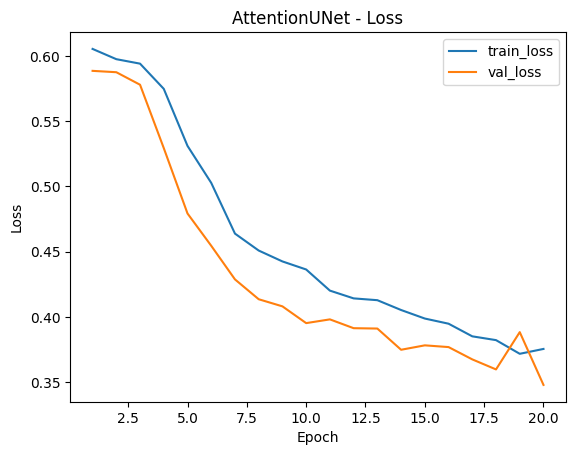

💾 Saved: /content/attn_unet_runs/AttentionUNet/20260117_185405/AttentionUNet_loss_curve.png


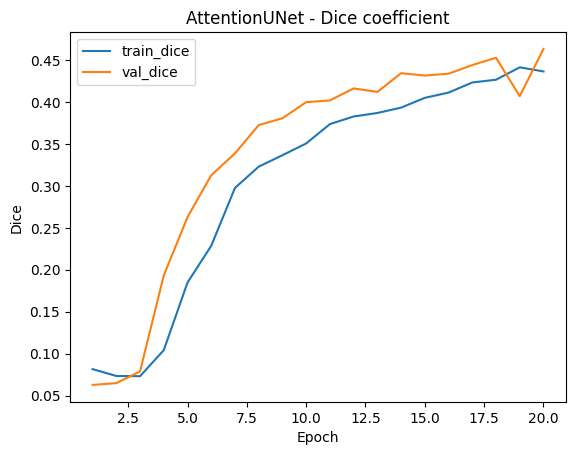

💾 Saved: /content/attn_unet_runs/AttentionUNet/20260117_185405/AttentionUNet_dice_curve.png


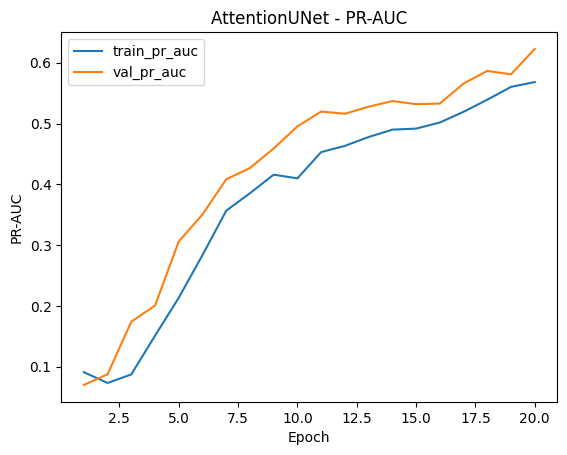

💾 Saved: /content/attn_unet_runs/AttentionUNet/20260117_185405/AttentionUNet_pr_auc_curve.png


In [ ]:
# =========================
# 29) Plot training curves
# Plots loss,dice and PR_AUC curves
# =========================

import os
import pandas as pd
import matplotlib.pyplot as plt

def plot_curves_from_history_dict(hist_dict, out_dir, model_name=None):
    epochs = range(1, len(hist_dict["loss"]) + 1)

    def _save_show(fig_title, ylab, series_pairs, filename):
        plt.figure()
        for y, label in series_pairs:
            if y is not None and len(y) > 0:
                plt.plot(epochs, y, label=label)
        plt.xlabel("Epoch")
        plt.ylabel(ylab)
        plt.title(fig_title if model_name is None else f"{model_name} - {fig_title}")
        plt.legend()
        out_path = os.path.join(out_dir, filename if model_name is None else f"{model_name}_{filename}")
        plt.savefig(out_path, dpi=300, bbox_inches="tight")
        plt.show()
        print("💾 Saved:", out_path)

    # 1) Loss
    _save_show(
        "Loss", "Loss",
        [
            (hist_dict.get("loss", []), "train_loss"),
            (hist_dict.get("val_loss", []), "val_loss"),
        ],
        "loss_curve.png"
    )

    # 2) Dice
    if "dice_coef" in hist_dict or "val_dice_coef" in hist_dict:
        _save_show(
            "Dice coefficient", "Dice",
            [
                (hist_dict.get("dice_coef", []), "train_dice"),
                (hist_dict.get("val_dice_coef", []), "val_dice"),
            ],
            "dice_curve.png"
        )

    # 3) PR-AUC
    if "pr_auc" in hist_dict or "val_pr_auc" in hist_dict:
        _save_show(
            "PR-AUC", "PR-AUC",
            [
                (hist_dict.get("pr_auc", []), "train_pr_auc"),
                (hist_dict.get("val_pr_auc", []), "val_pr_auc"),
            ],
            "pr_auc_curve.png"
        )


# -------------------------
# Main
# -------------------------
assert "OUT_DIR" in globals() and OUT_DIR is not None, "❌ OUT_DIR tanımlı değil."

_model_name = globals().get("MODEL_NAME", None)

# ---- Primary: use in-memory history ----
if "history" in globals() and hasattr(history, "history") and isinstance(history.history, dict) and "loss" in history.history:
    print("✅ Plotting from in-memory `history`")
    plot_curves_from_history_dict(history.history, OUT_DIR, model_name=_model_name)

# ---- Fallback: read CSV from OUT_DIR ----
else:
    assert _model_name is not None, "❌ MODEL_NAME bulunamadı (CSV fallback için gerekli)."
    csv_path = os.path.join(OUT_DIR, f"history_{_model_name}.csv")

    if os.path.exists(csv_path):
        print("✅ `history` not found. Reading:", csv_path)
        df = pd.read_csv(csv_path)

        hist = {
            "loss": df["loss"].tolist() if "loss" in df.columns else [],
            "val_loss": df["val_loss"].tolist() if "val_loss" in df.columns else [],
            "dice_coef": df["dice_coef"].tolist() if "dice_coef" in df.columns else [],
            "val_dice_coef": df["val_dice_coef"].tolist() if "val_dice_coef" in df.columns else [],
            "pr_auc": df["pr_auc"].tolist() if "pr_auc" in df.columns else [],
            "val_pr_auc": df["val_pr_auc"].tolist() if "val_pr_auc" in df.columns else [],
        }

        if len(hist["loss"]) == 0:
            raise ValueError("❌ CSV'de 'loss' kolonu yok veya boş. CSV içeriğini kontrol et.")

        plot_curves_from_history_dict(hist, OUT_DIR, model_name=_model_name)
    else:
        raise FileNotFoundError(f"❌ history CSV bulunamadı: {csv_path}")


✅ Loaded: /content/attn_unet_runs/AttentionUNet/20260117_185405/best_AttentionUNet.weights.h5

=== Test (pixel-level, thr=0.5) ===
TP: 79646 FP: 50934 FN: 58942 TN: 1711022
Precision: 0.609940266498622
Recall   : 0.5746962218909667
F1       : 0.591793472976181
IoU      : 0.42024672597154816


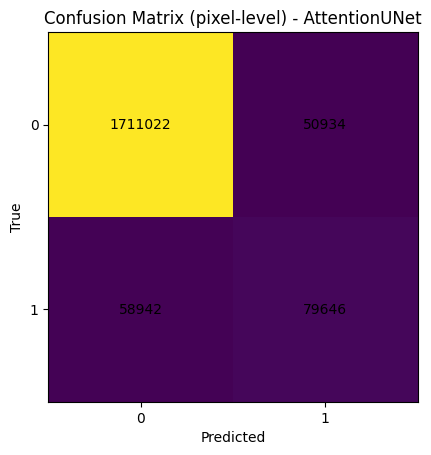

💾 Saved: /content/attn_unet_runs/AttentionUNet/20260117_185405/AttentionUNet_confusion_matrix.png

=== Best threshold (by F1 on TEST) [analysis] ===
Best thr: 0.22
Precision: 0.5684216724751638
Recall   : 0.6268724564852161
F1       : 0.5962174219748737


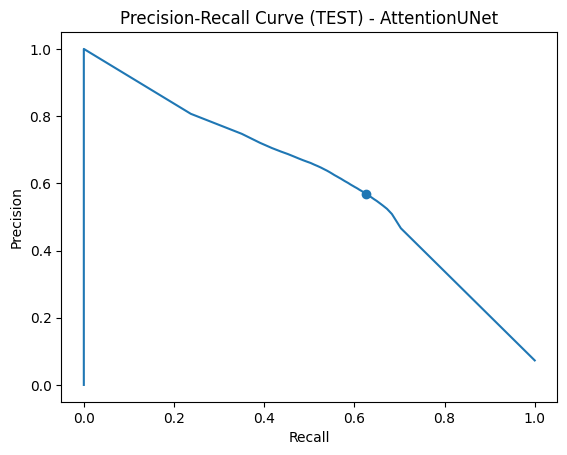

💾 Saved: /content/attn_unet_runs/AttentionUNet/20260117_185405/AttentionUNet_pr_curve.png
💾 Saved: /content/attn_unet_runs/AttentionUNet/20260117_185405/AttentionUNet_test_metrics.txt


In [ ]:
# =========================
# 30) Test evaluation + confusion matrix + PR curve
# Loads best weights and computes on test_ds and generates:
# confusion matrix stats (TP/TN/FP/FN)
# precision/recall/F1
# PR curve over thresholds
# =========================

import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

assert "OUT_DIR" in globals() and OUT_DIR is not None, "❌ OUT_DIR tanımlı değil."
assert "MODEL_NAME" in globals() and MODEL_NAME is not None, "❌ MODEL_NAME tanımlı değil."

# --- Load best weights (RUN-SAFE naming) ---
w_path = os.path.join(OUT_DIR, f"best_{MODEL_NAME}.weights.h5")
assert os.path.exists(w_path), f"❌ Best weights bulunamadı: {w_path}"
model.load_weights(w_path)
print("✅ Loaded:", w_path)

# --- settings ---
THR_FIXED = 0.5
THS = np.linspace(0, 1, 51)
eps = 1e-6

# --- accumulators ---
tp = tn = fp = fn = np.int64(0)
tp_t = np.zeros(len(THS), dtype=np.int64)
fp_t = np.zeros(len(THS), dtype=np.int64)
fn_t = np.zeros(len(THS), dtype=np.int64)

for xb, yb in test_ds:
    probs = model(xb, training=False).numpy().reshape(-1).astype(np.float32)
    trueb = yb.numpy().reshape(-1)
    trueb = (trueb >= 0.5).astype(np.uint8)

    # ----- fixed threshold confusion -----
    predb = (probs >= THR_FIXED).astype(np.uint8)

    tp += np.int64(((predb == 1) & (trueb == 1)).sum())
    tn += np.int64(((predb == 0) & (trueb == 0)).sum())
    fp += np.int64(((predb == 1) & (trueb == 0)).sum())
    fn += np.int64(((predb == 0) & (trueb == 1)).sum())

    # ----- PR sweep (RAM-safe) -----
    for i, thr in enumerate(THS):
        pred_i = (probs >= thr).astype(np.uint8)
        tp_t[i] += np.int64(((pred_i == 1) & (trueb == 1)).sum())
        fp_t[i] += np.int64(((pred_i == 1) & (trueb == 0)).sum())
        fn_t[i] += np.int64(((pred_i == 0) & (trueb == 1)).sum())

# ----- fixed threshold metrics -----
precision = float(tp / (tp + fp + eps))
recall    = float(tp / (tp + fn + eps))
f1        = float(2 * precision * recall / (precision + recall + eps))
iou       = float(tp / (tp + fp + fn + eps))

print("\n=== Test (pixel-level, thr=0.5) ===")
print("TP:", int(tp), "FP:", int(fp), "FN:", int(fn), "TN:", int(tn))
print("Precision:", precision)
print("Recall   :", recall)
print("F1       :", f1)
print("IoU      :", iou)

# ----- confusion matrix plot -----
cm = np.array([[int(tn), int(fp)],
               [int(fn), int(tp)]], dtype=np.int64)

plt.figure()
plt.imshow(cm)
plt.title(f"Confusion Matrix (pixel-level) - {MODEL_NAME}")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.xticks([0,1], ["0","1"])
plt.yticks([0,1], ["0","1"])
for (i,j), v in np.ndenumerate(cm):
    plt.text(j, i, str(v), ha="center", va="center")

cm_path = os.path.join(OUT_DIR, f"{MODEL_NAME}_confusion_matrix.png")
plt.savefig(cm_path, dpi=300, bbox_inches="tight")
plt.show()
print("💾 Saved:", cm_path)

# ----- PR curve + best threshold by F1 -----
P = tp_t / (tp_t + fp_t + eps)
R = tp_t / (tp_t + fn_t + eps)
F1s = 2 * P * R / (P + R + eps)

best_i = int(np.argmax(F1s))
best_thr = float(THS[best_i])
best_p, best_r, best_f1 = float(P[best_i]), float(R[best_i]), float(F1s[best_i])

print("\n=== Best threshold (by F1 on TEST) [analysis] ===")
print("Best thr:", best_thr)
print("Precision:", best_p)
print("Recall   :", best_r)
print("F1       :", best_f1)

plt.figure()
plt.plot(R, P)
plt.scatter([best_r], [best_p])
plt.title(f"Precision-Recall Curve (TEST) - {MODEL_NAME}")
plt.xlabel("Recall")
plt.ylabel("Precision")

pr_path = os.path.join(OUT_DIR, f"{MODEL_NAME}_pr_curve.png")
plt.savefig(pr_path, dpi=300, bbox_inches="tight")
plt.show()
print("💾 Saved:", pr_path)

# ----- save summary metrics -----
txt_path = os.path.join(OUT_DIR, f"{MODEL_NAME}_test_metrics.txt")
with open(txt_path, "w") as f:
    f.write("=== Fixed threshold (0.5) ===\n")
    f.write(f"weights={w_path}\n")
    f.write(f"threshold={THR_FIXED}\n")
    f.write(f"TP={int(tp)} FP={int(fp)} FN={int(fn)} TN={int(tn)}\n")
    f.write(f"precision={precision}\nrecall={recall}\nf1={f1}\niou={iou}\n\n")
    f.write("=== Best threshold (by F1 on TEST) [analysis] ===\n")
    f.write(f"best_threshold={best_thr}\n")
    f.write(f"precision={best_p}\nrecall={best_r}\nf1={best_f1}\n")

print("💾 Saved:", txt_path)


✅ Loaded weights: /content/attn_unet_runs/AttentionUNet/20260117_185405/best_AttentionUNet.weights.h5


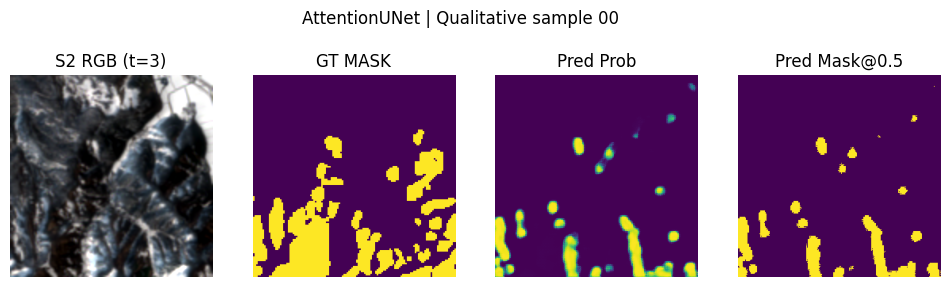

💾 Saved: /content/attn_unet_runs/AttentionUNet/20260117_185405/AttentionUNet_qual_00.png


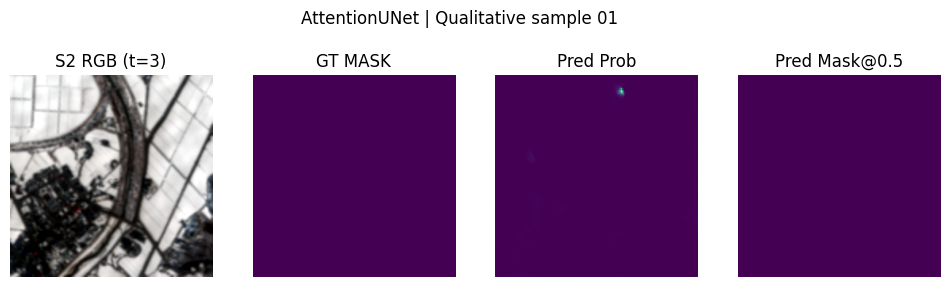

💾 Saved: /content/attn_unet_runs/AttentionUNet/20260117_185405/AttentionUNet_qual_01.png


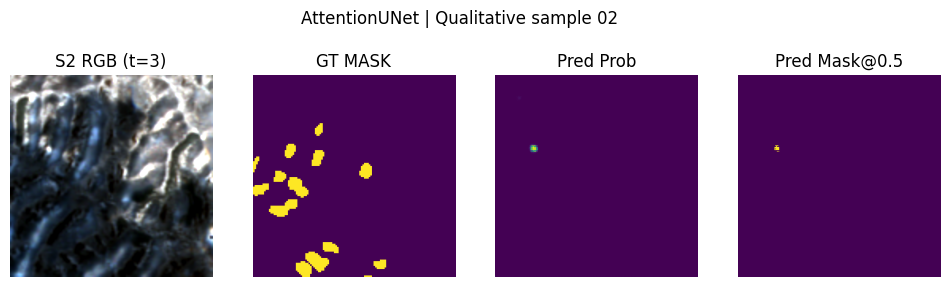

💾 Saved: /content/attn_unet_runs/AttentionUNet/20260117_185405/AttentionUNet_qual_02.png


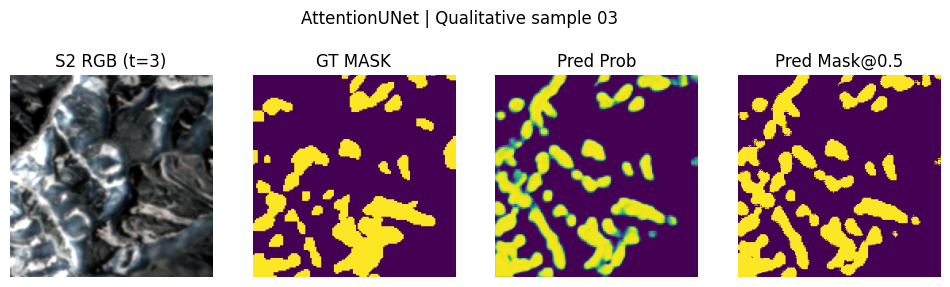

💾 Saved: /content/attn_unet_runs/AttentionUNet/20260117_185405/AttentionUNet_qual_03.png


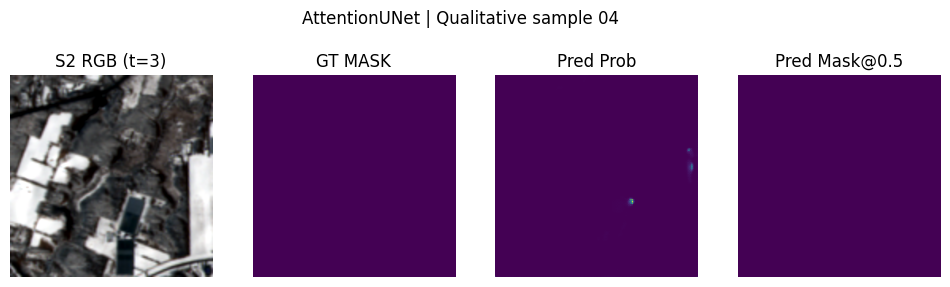

💾 Saved: /content/attn_unet_runs/AttentionUNet/20260117_185405/AttentionUNet_qual_04.png


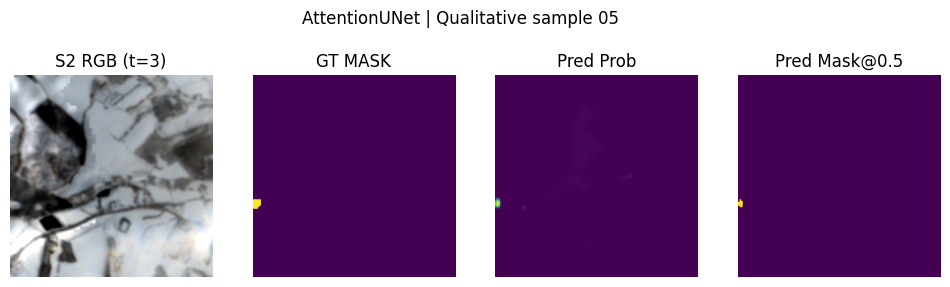

💾 Saved: /content/attn_unet_runs/AttentionUNet/20260117_185405/AttentionUNet_qual_05.png


In [ ]:
# =========================
# 31) Qualitative examples visualization
# Shows and saves:
# S2 RGB visualization (time-aware indexing)
# ground-truth mask
# predicted mask/probability
# =========================

import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

assert "OUT_DIR" in globals() and OUT_DIR, "❌ OUT_DIR yok."
assert "MODEL_NAME" in globals() and MODEL_NAME, "❌ MODEL_NAME yok."
assert "S1_VARS" in globals() and "S2_BANDS" in globals(), "❌ S1_VARS / S2_BANDS yok."
assert "TIME_STEPS" in globals(), "❌ TIME_STEPS yok."

# ---- load best weights (RUN-SAFE) ----
w_path = os.path.join(OUT_DIR, f"best_{MODEL_NAME}.weights.h5")
assert os.path.exists(w_path), f"❌ weights bulunamadı: {w_path}"
model.load_weights(w_path)
print("✅ Loaded weights:", w_path)

# -------------------------
# band lookup (B04 vs B4)
# -------------------------
def pick_band_idx(band_to_idx, wanted):
    if wanted in band_to_idx:
        return band_to_idx[wanted]
    alt = wanted.replace("B0", "B") if "B0" in wanted else wanted.replace("B", "B0")
    if alt in band_to_idx:
        return band_to_idx[alt]
    raise KeyError(f"Band {wanted} not found. Available: {list(band_to_idx.keys())[:15]} ...")

# -------------------------
# percentile stretch
# -------------------------
def stretch01(img, p_low=2, p_high=98):
    img = img.astype(np.float32)
    lo = np.percentile(img, p_low, axis=(0, 1), keepdims=True)
    hi = np.percentile(img, p_high, axis=(0, 1), keepdims=True)
    out = (img - lo) / (hi - lo + 1e-6)
    return np.clip(out, 0, 1)

# -------------------------
# TIME-aware indices
# Channel layout assumption (matches your to_time_sequence):
# [var0_t0..tT-1, var1_t0..tT-1, ...]
# Vars are ordered: S1asc vars, S1dsc vars, S2 vars (+optional DEM/SCL if you added them as vars)
# -------------------------
T = int(TIME_STEPS)
S2_START = 2 * len(S1_VARS) * T  # S1 asc + dsc blocks (each var has T channels)

band_to_idx = {b: i for i, b in enumerate(S2_BANDS)}  # within S2 vars only

# Which time slice to visualize (last)
SHOW_T = T - 1

# Get RGB var indices (within S2 vars)
r_var = pick_band_idx(band_to_idx, "B04")
g_var = pick_band_idx(band_to_idx, "B03")
b_var = pick_band_idx(band_to_idx, "B02")

# Convert (var_idx, t) -> channel_idx
R_idx = S2_START + r_var * T + SHOW_T
G_idx = S2_START + g_var * T + SHOW_T
B_idx = S2_START + b_var * T + SHOW_T

# bounds check (important!)
xb0, yb0 = next(iter(test_ds))
C = int(xb0.shape[-1])
assert max(R_idx, G_idx, B_idx) < C, (
    f"❌ RGB channel index out of bounds. "
    f"Got max_idx={max(R_idx,G_idx,B_idx)} but channels={C}. "
    f"Check channel order / N_CH / DEM-SCL handling."
)

# -------------------------
# threshold + how many samples
# -------------------------
THR = 0.5
N_SHOW = 6
saved = 0

for xb, yb in test_ds:
    probs = model(xb, training=False)  # tensor (B,H,W,1)
    probs = tf.cast(probs, tf.float32).numpy()

    xb_np = xb.numpy()
    yb_np = yb.numpy()

    for i in range(xb_np.shape[0]):
        x = xb_np[i]
        y = yb_np[i].squeeze()
        p = probs[i].squeeze()
        pred = (p >= THR).astype(np.uint8)

        rgb = np.stack([x[..., R_idx], x[..., G_idx], x[..., B_idx]], axis=-1)
        rgb = stretch01(rgb)

        plt.figure(figsize=(12,3))
        plt.suptitle(f"{MODEL_NAME} | Qualitative sample {saved:02d}", y=1.05, fontsize=12)
        plt.subplot(1,4,1); plt.imshow(rgb);  plt.title(f"S2 RGB (t={SHOW_T})"); plt.axis("off")
        plt.subplot(1,4,2); plt.imshow(y);    plt.title("GT MASK");            plt.axis("off")
        plt.subplot(1,4,3); plt.imshow(p);    plt.title("Pred Prob");          plt.axis("off")
        plt.subplot(1,4,4); plt.imshow(pred); plt.title(f"Pred Mask@{THR}");   plt.axis("off")

        out = os.path.join(OUT_DIR, f"{MODEL_NAME}_qual_{saved:02d}.png")
        plt.savefig(out, dpi=250, bbox_inches="tight")
        plt.show()
        print("💾 Saved:", out)

        saved += 1
        if saved >= N_SHOW:
            break
    if saved >= N_SHOW:
        break


In [ ]:
# =========================
# 32) summary cell
# =========================

import os, time, json
import numpy as np
import tensorflow as tf


req = ["OUT_DIR", "MODEL_NAME", "model", "test_ds", "TIME_STEPS", "TARGET_SIZE"]
missing = [k for k in req if k not in globals()]
assert not missing, f"❌ Missing globals: {missing}"

os.makedirs(OUT_DIR, exist_ok=True)

def _safe_len(name):
    v = globals().get(name, None)
    try:
        return len(v) if v is not None else None
    except Exception:
        return None

n_train = _safe_len("train_keys")
n_val   = _safe_len("val_keys")
n_test  = _safe_len("test_keys")

# Fallbacks (cardinality is batches, not tiles)
if n_train is None:
    n_train = "UNKNOWN"
if n_val is None:
    n_val = "UNKNOWN"
if n_test is None:
    n_test = "UNKNOWN"

gpus = tf.config.list_physical_devices("GPU")
hardware = f"GPU x{len(gpus)}" if len(gpus) > 0 else "CPU"


print("\n=== DATASET SPLIT INFORMATION ===")
print(f"Model            : {MODEL_NAME}")
print(f"Train tiles      : {n_train}")
print(f"Validation tiles : {n_val}")
print(f"Test tiles       : {n_test}")
print(f"Time steps       : {int(TIME_STEPS)}")
print(f"Input size       : {int(TARGET_SIZE)} x {int(TARGET_SIZE)}")
print(f"OUT_DIR          : {OUT_DIR}")

split_txt = os.path.join(OUT_DIR, f"{MODEL_NAME}_dataset_split.txt")
with open(split_txt, "w") as f:
    f.write("Dataset split information\n")
    f.write("==========================\n")
    f.write(f"Model            : {MODEL_NAME}\n")
    f.write(f"Train tiles      : {n_train}\n")
    f.write(f"Validation tiles : {n_val}\n")
    f.write(f"Test tiles       : {n_test}\n")
    f.write(f"Time steps       : {int(TIME_STEPS)}\n")
    f.write(f"Input size       : {int(TARGET_SIZE)} x {int(TARGET_SIZE)}\n")
    f.write(f"OUT_DIR          : {OUT_DIR}\n")
print("✅ Saved to:", split_txt)


N_WARMUP = 2
N_RUNS   = 10

times = []
tiles = 0
batches = 0

it = iter(test_ds)

# Warmup (stop if dataset ends)
for _ in range(N_WARMUP):
    try:
        xb, _ = next(it)
    except StopIteration:
        break
    _ = model(xb, training=False)

# Timed runs (stop if dataset ends)
for _ in range(N_RUNS):
    try:
        xb, _ = next(it)
    except StopIteration:
        break

    start = time.time()
    _ = model(xb, training=False)
    end = time.time()

    times.append(end - start)
    tiles += int(xb.shape[0])
    batches += 1

if tiles == 0:
    ms_per_tile = float("nan")
    print("\n=== INFERENCE SPEED ===")
    print(f"Hardware         : {hardware}")
    print("⚠️ Speed test skipped: test_ds ended before timed runs.")
else:
    ms_per_tile = (float(np.sum(times)) / tiles) * 1000.0
    print("\n=== INFERENCE SPEED ===")
    print(f"Hardware         : {hardware}")
    print(f"Timed batches    : {batches} | tiles measured: {tiles}")
    print(f"Inference time   : {ms_per_tile:.2f} ms per tile ({TARGET_SIZE}x{TARGET_SIZE})")

speed_txt = os.path.join(OUT_DIR, f"{MODEL_NAME}_inference_speed.txt")
with open(speed_txt, "w") as f:
    f.write("Inference speed\n")
    f.write("================\n")
    f.write(f"Model          : {MODEL_NAME}\n")
    f.write(f"Hardware       : {hardware}\n")
    f.write(f"Warmup         : {N_WARMUP}\n")
    f.write(f"Requested runs : {N_RUNS}\n")
    f.write(f"Timed batches  : {batches}\n")
    f.write(f"Tiles measured : {tiles}\n")
    f.write(f"ms_per_tile    : {ms_per_tile}\n")
print("✅ Saved to:", speed_txt)


summary_path = os.path.join(OUT_DIR, f"{MODEL_NAME}_paper_summary.json")
summary = {
    "MODEL_NAME": str(MODEL_NAME),
    "train_tiles": n_train,
    "val_tiles": n_val,
    "test_tiles": n_test,
    "TIME_STEPS": int(TIME_STEPS),
    "TARGET_SIZE": int(TARGET_SIZE),
    "hardware": hardware,
    "tiles_measured_speed": int(tiles),
    "timed_batches_speed": int(batches),
    "ms_per_tile": float(ms_per_tile) if np.isfinite(ms_per_tile) else None,
    "OUT_DIR": str(OUT_DIR),
}
with open(summary_path, "w") as f:
    json.dump(summary, f, indent=2)
print("✅ Saved to:", summary_path)



=== DATASET SPLIT INFORMATION ===
Model            : AttentionUNet
Train tiles      : 232
Validation tiles : 29
Test tiles       : 29
Time steps       : 4
Input size       : 256 x 256
OUT_DIR          : /content/attn_unet_runs/AttentionUNet/20260117_185405
✅ Saved to: /content/attn_unet_runs/AttentionUNet/20260117_185405/AttentionUNet_dataset_split.txt

=== INFERENCE SPEED ===
Hardware         : GPU x1
Timed batches    : 6 | tiles measured: 21
Inference time   : 66.30 ms per tile (256x256)
✅ Saved to: /content/attn_unet_runs/AttentionUNet/20260117_185405/AttentionUNet_inference_speed.txt
✅ Saved to: /content/attn_unet_runs/AttentionUNet/20260117_185405/AttentionUNet_paper_summary.json


In [ ]:
# =========================
# 33) Inference speed benchmark
# Measures average inference time per tile with warmup, avoids StopIteration, saves to file.
# =========================

import os, time
import numpy as np
import tensorflow as tf

assert "OUT_DIR" in globals(), "OUT_DIR yok"
os.makedirs(OUT_DIR, exist_ok=True)

# --- settings ---
N_WARMUP = 2
N_RUNS   = 10

times = []
tiles = 0

it = iter(test_ds)

# warmup
for _ in range(N_WARMUP):
    try:
        xb, _ = next(it)
        _ = model(xb, training=False)
    except StopIteration:
        break

# timed runs (stop if dataset ends)
for _ in range(N_RUNS):
    try:
        xb, _ = next(it)
    except StopIteration:
        break

    start = time.time()
    _ = model(xb, training=False)
    end = time.time()

    times.append(end - start)
    tiles += int(xb.shape[0])

if tiles == 0 or len(times) == 0:
    print("⚠️ Speed test skipped: test_ds ended before timed runs.")
else:
    ms_per_tile = (np.sum(times) / tiles) * 1000.0
    print("\n=== INFERENCE SPEED ===")
    print(f"Inference time ≈ {ms_per_tile:.2f} ms per tile (256x256)")
    print(f"Measured tiles : {tiles} | batches: {len(times)}")
    print(f"Hardware       : GPUs={len(tf.config.list_physical_devices('GPU'))}")

    speed_txt = os.path.join(OUT_DIR, "inference_speed.txt")
    with open(speed_txt, "w") as f:
        f.write("Inference speed\n")
        f.write("================\n")
        f.write(f"ms_per_tile={ms_per_tile:.4f}\n")
        f.write(f"tiles={tiles}\n")
        f.write(f"batches={len(times)}\n")
        f.write(f"target_size={TARGET_SIZE}\n")
        f.write(f"gpu_count={len(tf.config.list_physical_devices('GPU'))}\n")
    print("✅ Saved to:", speed_txt)



=== INFERENCE SPEED ===
Inference time ≈ 72.73 ms per tile (256x256)
Measured tiles : 21 | batches: 6
Hardware       : GPUs=1
✅ Saved to: /content/attn_unet_runs/AttentionUNet/20260117_185405/inference_speed.txt


In [ ]:
# =========================
# 34) Zip results
# =========================

!zip -r attn_unet_runs.zip /content/attn_unet_runs


updating: content/attn_unet_runs/ (stored 0%)
updating: content/attn_unet_runs/VanillaUNet/ (stored 0%)
updating: content/attn_unet_runs/VanillaUNet/20260117_161050/ (stored 0%)
updating: content/attn_unet_runs/VanillaUNet/20260117_161050/VanillaUNet_qual_01.png (deflated 3%)
updating: content/attn_unet_runs/VanillaUNet/20260117_161050/VanillaUNet_confusion_matrix.png (deflated 22%)
updating: content/attn_unet_runs/VanillaUNet/20260117_161050/inference_speed.txt (deflated 16%)
updating: content/attn_unet_runs/VanillaUNet/20260117_161050/history_VanillaUNet.csv (deflated 56%)
updating: content/attn_unet_runs/VanillaUNet/20260117_161050/VanillaUNet_pr_auc_curve.png (deflated 13%)
updating: content/attn_unet_runs/VanillaUNet/20260117_161050/VanillaUNet_paper_summary.json (deflated 32%)
updating: content/attn_unet_runs/VanillaUNet/20260117_161050/VanillaUNet_inference_speed.txt (deflated 28%)
updating: content/attn_unet_runs/VanillaUNet/20260117_161050/VanillaUNet_test_metrics.txt (deflate

In [2]:
from google.colab import drive
drive.mount("/content/drive")

!ls /content/drive/MyDrive/attention_unet/results_attention/

!cp -r /content/attn_unet_runs \
/content/drive/MyDrive/attention_unet/results_attention/

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
attn_unet_runs	attn_unet_runs_vanilla
cp: cannot stat '/content/attn_unet_runs': No such file or directory


In [ ]:
!ls /content/drive/MyDrive/attention_unet/results_attention/attn_unet_runs


AttentionUNet  benchmark  run1	TemporalUNet_ConvLSTM  VanillaUNet


In [ ]:
# =========================
# 35) End-of-run benchmark cell
# Another “end-of-run” benchmark section (saves CSV/JSON/PNG).
# (This overlaps conceptually with Cells 41–42; it’s like an extra final pack.
# =========================

import os, json, time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --------- REQUIRED: these should already exist in your notebook ----------
# MODEL_NAME : str  (e.g., "VanillaUNet", "AttentionUNet", "ConvLSTM")
# model      : tf.keras.Model (built architecture)
# BEST_WEIGHTS_PATH : str (path to best_*.weights.h5)  [or WEIGHTS_PATH]
# x_test, y_test OR test_ds (tf.data.Dataset)
# ------------------------------------------------------------------------

THRESHOLD = 0.5

# --- infer MODEL_NAME robustly ---
if "MODEL_NAME" not in globals() or not isinstance(MODEL_NAME, str) or len(MODEL_NAME) == 0:
    MODEL_NAME = model.name if "model" in globals() else "UnknownModel"

# --- locate weights path robustly ---
BEST_WEIGHTS_PATH = None
for cand in ["BEST_WEIGHTS_PATH", "best_weights_path", "WEIGHTS_PATH", "weights_path"]:
    if cand in globals() and isinstance(globals()[cand], str) and len(globals()[cand]) > 0:
        BEST_WEIGHTS_PATH = globals()[cand]
        break

if BEST_WEIGHTS_PATH is None:
    # last resort: try to find "best_<MODEL_NAME>.weights.h5" under common output folders
    SEARCH_ROOTS = ["/content/attn_unet_runs", "/content/drive/MyDrive", "/content"]
    pattern = f"best_{MODEL_NAME}.weights.h5"
    found = []
    for root in SEARCH_ROOTS:
        if os.path.exists(root):
            for dirpath, dirnames, filenames in os.walk(root):
                if pattern in filenames:
                    found.append(os.path.join(dirpath, pattern))
    if len(found) == 0:
        raise FileNotFoundError(
            f"Could not find best weights for {MODEL_NAME}. "
            f"Please set BEST_WEIGHTS_PATH explicitly."
        )
    # choose most recent
    found.sort(key=lambda p: os.path.getmtime(p), reverse=True)
    BEST_WEIGHTS_PATH = found[0]

assert os.path.exists(BEST_WEIGHTS_PATH), f"Weights not found: {BEST_WEIGHTS_PATH}"

# --- get evaluation data (x_eval, y_eval) ---
def dataset_to_numpy(ds):
    xs, ys = [], []
    for xb, yb in ds:
        xs.append(xb.numpy())
        ys.append(yb.numpy())
    return np.concatenate(xs, axis=0), np.concatenate(ys, axis=0)

if "test_ds" in globals() and test_ds is not None:
    x_eval, y_eval = dataset_to_numpy(test_ds)
elif "TEST_DATASET" in globals() and TEST_DATASET is not None:
    x_eval, y_eval = dataset_to_numpy(TEST_DATASET)
elif "x_test" in globals() and "y_test" in globals() and x_test is not None and y_test is not None:
    x_eval, y_eval = np.array(x_test), np.array(y_test)
else:
    raise ValueError("Provide test_ds (preferred) or x_test & y_test arrays.")

# --- binarize GT ---
y_true = (y_eval > 0.5).astype(np.uint8)
if y_true.ndim == 4 and y_true.shape[-1] == 1:
    y_true = y_true[..., 0]  # (N,H,W)

pos_pixels = int(y_true.sum())
total_pixels = int(np.prod(y_true.shape))
pos_ratio = float(pos_pixels / max(total_pixels, 1))

# --- load best weights into current model ---
model.load_weights(BEST_WEIGHTS_PATH)

# --- predict ---
t0 = time.time()
y_prob = model.predict(x_eval, batch_size=8, verbose=0)
infer_s = time.time() - t0

if y_prob.ndim == 4 and y_prob.shape[-1] == 1:
    y_prob = y_prob[..., 0]
y_pred = (y_prob >= THRESHOLD).astype(np.uint8)

# --- confusion & metrics ---
def safe_div(a, b): return float(a / b) if b != 0 else 0.0

yt = y_true.reshape(-1).astype(np.uint8)
yp = y_pred.reshape(-1).astype(np.uint8)
tp = int(((yt == 1) & (yp == 1)).sum())
fp = int(((yt == 0) & (yp == 1)).sum())
fn = int(((yt == 1) & (yp == 0)).sum())
tn = int(((yt == 0) & (yp == 0)).sum())

precision = safe_div(tp, tp + fp)
recall    = safe_div(tp, tp + fn)
f1_dice   = safe_div(2 * tp, 2 * tp + fp + fn)
iou       = safe_div(tp, tp + fp + fn)
accuracy  = safe_div(tp + tn, tp + tn + fp + fn)

row = {
    "model": MODEL_NAME,
    "threshold": THRESHOLD,
    "precision": precision,
    "recall": recall,
    "f1_dice": f1_dice,
    "iou": iou,
    "accuracy": accuracy,
    "tp": tp, "fp": fp, "fn": fn, "tn": tn,
    "pos_pixels": pos_pixels,
    "pos_ratio": pos_ratio,
    "infer_seconds_total": infer_s,
    "infer_seconds_per_sample": safe_div(infer_s, int(y_true.shape[0])),
    "weights_path": BEST_WEIGHTS_PATH,
    "n_samples": int(y_true.shape[0]),
}

df = pd.DataFrame([row])

# --- save folder (shared across runs) ---
# Put benchmark artifacts next to your run outputs if you have RUN_DIR; else fallback
RUN_DIR = None
for var in ["RUN_DIR", "run_dir", "OUT_DIR", "output_dir", "BASE_OUTDIR"]:
    if var in globals():
        RUN_DIR = globals()[var]
        break
if RUN_DIR is None:
    RUN_DIR = "/content/attn_unet_runs"

BENCH_DIR = os.path.join(RUN_DIR, "benchmark")
os.makedirs(BENCH_DIR, exist_ok=True)

# --- append to a master CSV so each run adds one row ---
master_csv = os.path.join(BENCH_DIR, "benchmark_master.csv")
if os.path.exists(master_csv):
    old = pd.read_csv(master_csv)
    # replace existing row for same model (keeps last run)
    old = old[old["model"] != MODEL_NAME]
    out = pd.concat([old, df], ignore_index=True)
else:
    out = df.copy()

out.to_csv(master_csv, index=False)

# --- save per-model JSON/CSV ---
per_csv  = os.path.join(BENCH_DIR, f"{MODEL_NAME}_benchmark_thr{THRESHOLD}.csv")
per_json = os.path.join(BENCH_DIR, f"{MODEL_NAME}_benchmark_thr{THRESHOLD}.json")
df.to_csv(per_csv, index=False)
with open(per_json, "w") as f:
    json.dump(row, f, indent=2)

# --- render table as PNG (model name embedded) ---
vis_cols = ["model","precision","recall","f1_dice","iou","accuracy","pos_ratio"]
df_vis = df[vis_cols].copy()
for c in df_vis.columns:
    if c != "model":
        df_vis[c] = df_vis[c].astype(float).round(4)

fig, ax = plt.subplots(figsize=(12, 2.2))
ax.axis("off")
tbl = ax.table(cellText=df_vis.values, colLabels=df_vis.columns, cellLoc="center", loc="center")
tbl.auto_set_font_size(False)
tbl.set_fontsize(10)
tbl.scale(1.2, 1.6)

title = f"Benchmark: {MODEL_NAME} | thr={THRESHOLD} | pos_ratio={pos_ratio:.4f} | n={row['n_samples']}"
plt.suptitle(title, fontsize=12, fontweight="bold", y=1.08)

png_path = os.path.join(BENCH_DIR, f"{MODEL_NAME}_benchmark_thr{THRESHOLD}.png")
plt.savefig(png_path, bbox_inches="tight", dpi=300)
plt.close()

# --- print results ---
display(df)
print("\nSaved benchmark artifacts:")
print("  master CSV :", master_csv)
print("  per-model  :", per_csv)
print("  per-model  :", per_json)
print("  PNG        :", png_path)
print("  weights    :", BEST_WEIGHTS_PATH)


,model,threshold,precision,recall,f1_dice,iou,accuracy,tp,fp,fn,tn,pos_pixels,pos_ratio,infer_seconds_total,infer_seconds_per_sample,weights_path,n_samples
0,AttentionUNet,0.5,0.520333,0.608429,0.560943,0.389799,0.930547,84321,77731,54267,1684225,138588,0.07292,51.024729,1.759473,/content/drive/MyDrive/attention_unet/results_...,29



Saved benchmark artifacts:
  master CSV : /content/attn_unet_runs/benchmark/benchmark_master.csv
  per-model  : /content/attn_unet_runs/benchmark/AttentionUNet_benchmark_thr0.5.csv
  per-model  : /content/attn_unet_runs/benchmark/AttentionUNet_benchmark_thr0.5.json
  PNG        : /content/attn_unet_runs/benchmark/AttentionUNet_benchmark_thr0.5.png
  weights    : /content/drive/MyDrive/attention_unet/results_attention/attn_unet_runs/AttentionUNet/20260117_180055/best_AttentionUNet.weights.h5


In [ ]:
# =========================
# 36) Zip again
# Creates zip again (duplicate safety)
# =========================
!zip -r attn_unet_runs.zip /content/attn_unet_runs

updating: content/attn_unet_runs/ (stored 0%)
updating: content/attn_unet_runs/VanillaUNet/ (stored 0%)
updating: content/attn_unet_runs/VanillaUNet/20260117_161050/ (stored 0%)
updating: content/attn_unet_runs/VanillaUNet/20260117_161050/VanillaUNet_qual_01.png (deflated 3%)
updating: content/attn_unet_runs/VanillaUNet/20260117_161050/VanillaUNet_confusion_matrix.png (deflated 22%)
updating: content/attn_unet_runs/VanillaUNet/20260117_161050/inference_speed.txt (deflated 16%)
updating: content/attn_unet_runs/VanillaUNet/20260117_161050/history_VanillaUNet.csv (deflated 56%)
updating: content/attn_unet_runs/VanillaUNet/20260117_161050/VanillaUNet_pr_auc_curve.png (deflated 13%)
updating: content/attn_unet_runs/VanillaUNet/20260117_161050/VanillaUNet_paper_summary.json (deflated 32%)
updating: content/attn_unet_runs/VanillaUNet/20260117_161050/VanillaUNet_inference_speed.txt (deflated 28%)
updating: content/attn_unet_runs/VanillaUNet/20260117_161050/VanillaUNet_test_metrics.txt (deflate

In [ ]:
# =========================
# 37) Download zip to local computer
# Downloads attn_unet_runs.zip to your PC via Colab.
# =========================
from google.colab import files
files.download("attn_unet_runs.zip")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>